In [1]:
# import pyBigWig
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from pyliftover import LiftOver
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
# from pybedtools import BedTool
from collections import defaultdict
import pysam
from sklearn.metrics import roc_curve, auc
from scipy.stats import spearmanr, pearsonr
from collections import defaultdict

In [2]:
# These are the necessary files to run the rest of the notebook, make sure you have them all in the folder

sequences_bed_path = 'sequences.bed'

shah_tracks = ['GSM5669183_CardiacMyocytes_rep1_LB1.bigwig',
               'GSM5669188_APS_rep1_LB1.bigwig',
               'GSM5669193_BorderEctoderm_rep1_LB1.bigwig',
               'GSM5669198_D5Midbrain_rep1_LB1.bigwig',
               'GSM5669203_DefEctoderm_rep1_LB1.bigwig',
               'GSM5669209_EarlySomite_rep1_LB1.bigwig',
               'GSM5669214_EndoProgenitor_rep1_LB1.bigwig',
               'GSM5669220_Epicardium_rep1_LB1.bigwig',
               'GSM5669226_H9ESC_rep1_LB1.bigwig',
               'GSM5669232_Liver_rep1_LB1.bigwig',
               'GSM5669238_MidHindgut_rep1_LB1.bigwig',
               'GSM5669244_ParaxMesoderm_rep1_LB1.bigwig']
dimelo_tracks = ['HEK293_LMNB1','GM12878_LMNB1','HEK293_CpG_methylation','HEK293_CpG_motifs','GM12878_CpG_methylation','GM12878_CpG_motifs']

all_tracks = [shah_track[0:-16] for shah_track in shah_tracks] + dimelo_tracks

# /clusterfs/nilah/oberon/datasets/cs282a/
dataset_filepath = '/clusterfs/nilah/oberon/datasets/cs282a/dataset_14-lmnb1_4-cpg.h5'

cm_LAD_tabix_str = 'GSM5669183_CardiacMyocytes_LADs.sorted.bed.gz'
fl_LAD_tabix_str = '/clusterfs/nilah/oberon/datasets/lamina_association_shah/GSM5669232_Liver_LADs.sorted.bed.gz'

# /clusterfs/nilah/oberon/datasets/cs282a/inference/
linear_probe_inference = '/clusterfs/nilah/oberon/datasets/cs282a/inference/probe_first_full_run.h5'
multilayer_inference = 'mlp_model_20231128_063541_2.h5'
maxpool_inference = 'maxpool_model_20231128_072156_3.h5'
transformer_inference = 'transformer_model_20231128_080512_7.h5'

In [3]:
h5_files_dict = {
    'linear-probe':(linear_probe_inference,'128bp_bins'),
    'conv-perceptron':(multilayer_inference,'single_bin'),
    'maxpool-perceptron':(maxpool_inference,'single_bin'),
    'transformer':(transformer_inference,'single_bin'),
}

In [4]:
# These are approximate chromosome lengths from the hg38 reference genome
chrom_lengths = {    
    'chr1':249000000,
    'chr2':243000000,
    'chr3':198000000,
    'chr4':191000000,
    'chr5':182000000,
    'chr6':171000000,
    'chr7':160000000,
    'chr8':146000000,
    'chr9':140000000,
    'chr10':135000000,
    'chr11':135000000,
    'chr12':133000000,
    'chr13':113500000,
    'chr14':107000000,
    'chr15':102000000,
    'chr16':90000000,
    'chr17':84000000,
    'chr18':80000000,
    'chr19':59000000,
    'chr20':66000000,
    'chr21':48000000,
    'chr22':51000000,
    'chrX':155000000,
}

In [5]:
cm_LADs_tabix = pysam.TabixFile(cm_LAD_tabix_str)
fl_LADs_tabix = pysam.TabixFile(fl_LAD_tabix_str)
# If you have memory limitations, you may prefer to run a subset of chromosomes. 
# chr14 (element 13 of the list) is almost entirely test set so that is a good choice for assessing
plot_chroms = list(chrom_lengths.keys())
chrom_results = {}
for plot_chrom in tqdm(plot_chroms):
    plot_startco = 0
    plot_endco = chrom_lengths[plot_chrom]
    plot_xcoord = np.arange(start=plot_startco,stop=plot_endco,step=128)
    length = len(plot_xcoord)
    h5py_files = {}
    default_array = np.full((length, 18), np.nan,dtype=float)
    def default_factory():
        return default_array.copy()
    output_arrays = defaultdict(default_factory)
    plot_array_low_res = np.full((length, 18), np.nan)
    plot_array_high_res = np.full((length, 18), np.nan)
    cm_lads_array = np.zeros(length)
    fl_lads_array = np.zeros(length)
    test_train_split_array = np.zeros(length)


    buffer_at_ends = 8192
    seqbedlen = 38171
    test_train_split_array
    with open(sequences_bed_path,'r') as bed_file, h5py.File(dataset_filepath,'r') as f:
        for key, file_path in h5_files_dict.items():
            h5py_files[key]=h5py.File(file_path[0],'r')

        for index,bed_line in tqdm(enumerate(bed_file),total=seqbedlen,desc=f'reading labels and predictions for {plot_chrom}'):
            location_fields = bed_line.split('\t')
            chrom = str(location_fields[0])
            start = int(location_fields[1])+buffer_at_ends
            end = int(location_fields[2])-buffer_at_ends  
            set_int = 0
            if location_fields[3].strip()=='train':
                set_int = 1
            elif location_fields[3].strip()=='valid':
                set_int = 2
            elif location_fields[3].strip()=='test':
                set_int = 3

            cm_lad_type = 0
            fl_lad_type = 0
            for interval in cm_LADs_tabix.fetch(plot_chrom,start,end):
                fields = interval.split('\t')
                cm_lad_type = max(int(fields[3][1]),cm_lad_type)
                
            for interval in fl_LADs_tabix.fetch(plot_chrom,start,end):
                fields = interval.split('\t')
                fl_lad_type = max(int(fields[3][1]),fl_lad_type)

            if end>plot_startco and start<plot_endco and chrom==plot_chrom:
                if start>plot_startco and end<plot_endco:
                    for key,file_details in h5_files_dict.items():
                        output_arrays[key][(start-plot_startco)//128:(end-plot_startco)//128,:] = h5py_files[key][file_details[1]][index,:,:]
                    plot_array_low_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = f['single_bin'][index,:,:]
                    plot_array_high_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = f['128bp_bins'][index,:,:]
                    cm_lads_array[(start-plot_startco)//128:(end-plot_startco)//128] = cm_lad_type
                    fl_lads_array[(start-plot_startco)//128:(end-plot_startco)//128] = fl_lad_type
                    test_train_split_array[(start-plot_startco)//128:(end-plot_startco)//128] = set_int
    chrom_results[plot_chrom] = (
        plot_xcoord,
        plot_array_low_res,
        plot_array_high_res,
        output_arrays,
        cm_lads_array,
        fl_lads_array,
        test_train_split_array,
    )

  0%|          | 0/23 [00:00<?, ?it/s]

reading labels and predictions for chr1:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr2:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr3:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr4:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr5:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr6:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr7:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr8:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr9:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr10:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr11:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr12:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr13:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr14:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr15:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr16:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr17:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr18:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr19:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr20:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr21:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chr22:   0%|          | 0/38171 [00:00<?, ?it/s]

reading labels and predictions for chrX:   0%|          | 0/38171 [00:00<?, ?it/s]

In [6]:
# This cell simply spits out the composition of each chromosome in terms of test/train/validation split, as 
# well as unindexed portions (mostly repetitive regions that are left out of training, e.g. centromeres)
sets_strings_dict = {}
for plot_chrom in plot_chroms:
    (
        plot_xcoord,
        plot_array_low_res,
        plot_array_high_res,
        output_arrays,
        cm_lads_array,
        fl_lads_array,
        test_train_split_array,
    ) = chrom_results[plot_chrom]
    unindexed_num = np.sum(test_train_split_array==0)
    train_num = np.sum(test_train_split_array==1)
    valid_num = np.sum(test_train_split_array==2)
    test_num = np.sum(test_train_split_array==3)
    total_num = train_num + valid_num + test_num + unindexed_num
    sets_string = f'{100*train_num/total_num:.2f}% training set, {100*valid_num/total_num:.2f}% validation set, {100*test_num/total_num:.2f}% test set, {100*unindexed_num/total_num:.2f}% unindexed'
    print(plot_chrom,sets_string)
    sets_strings_dict[plot_chrom] = sets_string

chr1 85.88% training set, 0.46% validation set, 0.46% test set, 13.20% unindexed
chr2 70.24% training set, 22.65% validation set, 1.65% test set, 5.45% unindexed
chr3 86.62% training set, 2.84% validation set, 7.99% test set, 2.55% unindexed
chr4 96.69% training set, 0.00% validation set, 0.06% test set, 3.25% unindexed
chr5 91.72% training set, 3.15% validation set, 0.00% test set, 5.13% unindexed
chr6 84.46% training set, 11.94% validation set, 0.47% test set, 3.13% unindexed
chr7 85.44% training set, 5.02% validation set, 0.50% test set, 9.04% unindexed
chr8 93.19% training set, 0.47% validation set, 1.26% test set, 5.09% unindexed
chr9 77.05% training set, 0.00% validation set, 0.00% test set, 22.95% unindexed
chr10 92.58% training set, 0.34% validation set, 0.68% test set, 6.40% unindexed
chr11 74.00% training set, 2.21% validation set, 17.16% test set, 6.63% unindexed
chr12 94.25% training set, 1.03% validation set, 0.86% test set, 3.85% unindexed
chr13 67.82% training set, 13.64

In [7]:
set_dict = {
    'train':1,
    'valid':2,
    'test':3,
}
plot_arrays_low_res_list = []
plot_arrays_high_res_list = []
output_arrays_lists_dict = defaultdict(list)
cm_lads_arrays_list = []
fl_lads_arrays_list = []
test_train_split_arrays_list = []
for plot_chrom in plot_chroms:
    (
    plot_xcoord,
    plot_array_low_res,
    plot_array_high_res,
    output_arrays,
    cm_lads_array,
    fl_lads_array,
    test_train_split_array,
    ) = chrom_results[plot_chrom]
    plot_arrays_low_res_list.append(plot_array_low_res)
    plot_arrays_high_res_list.append(plot_array_high_res)
    for key,value in output_arrays.items():
        output_arrays_lists_dict[key].append(value)
    cm_lads_arrays_list.append(cm_lads_array)
    fl_lads_arrays_list.append(fl_lads_array)
    test_train_split_arrays_list.append(test_train_split_array)
print('concatenating chromosome arrays')
plot_array_low_res_concat = np.concatenate(plot_arrays_low_res_list,axis=0)
plot_array_high_res_concat = np.concatenate(plot_arrays_high_res_list,axis=0)
output_arrays_concat = {}
for key,value in output_arrays_lists_dict.items():
    output_arrays_concat[key] = np.concatenate(value,axis=0)
cm_lads_array_concat = np.concatenate(cm_lads_arrays_list,axis=0)
fl_lads_array_concat = np.concatenate(fl_lads_arrays_list,axis=0)
test_train_split_array_concat = np.concatenate(test_train_split_arrays_list,axis=0)

concatenating chromosome arrays


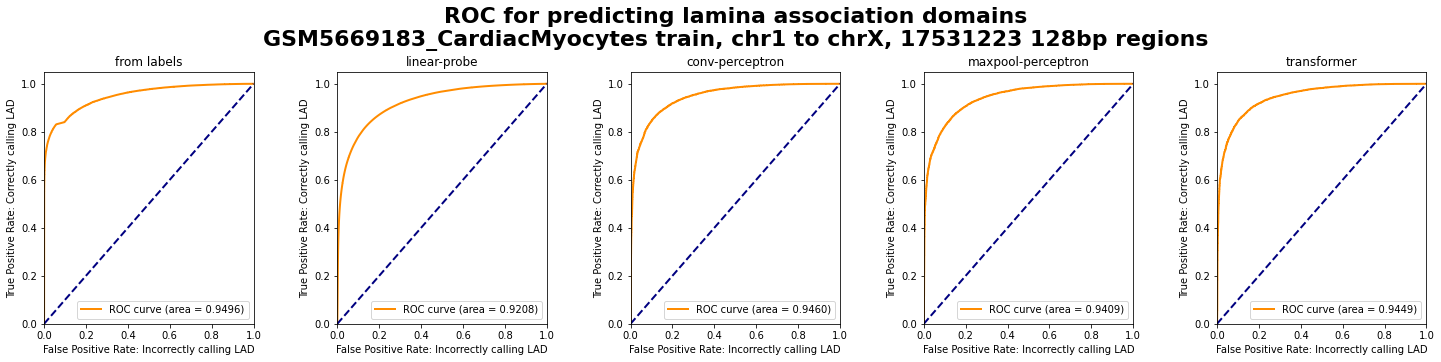

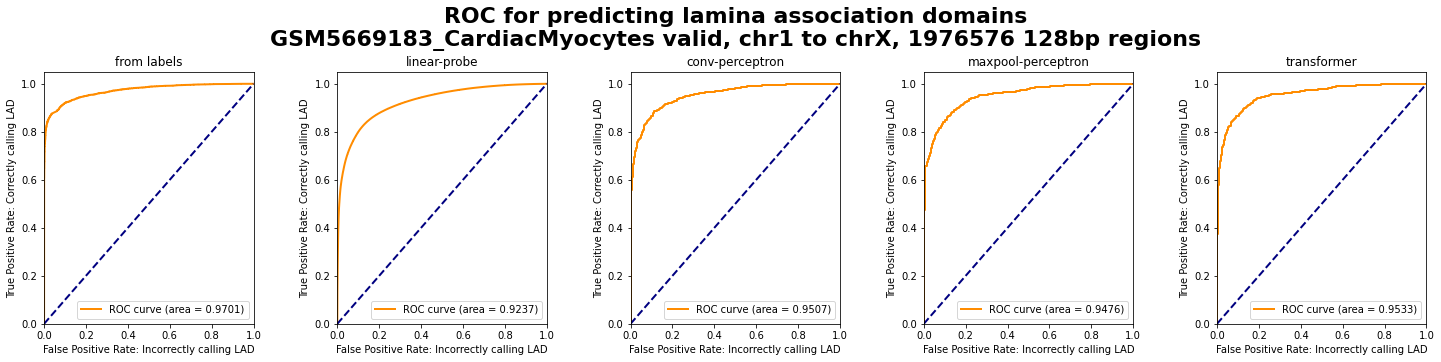

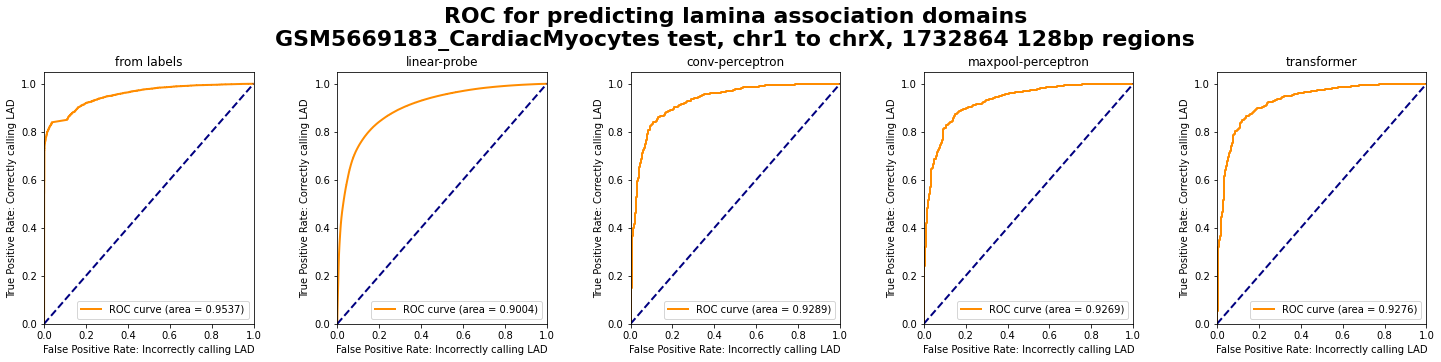

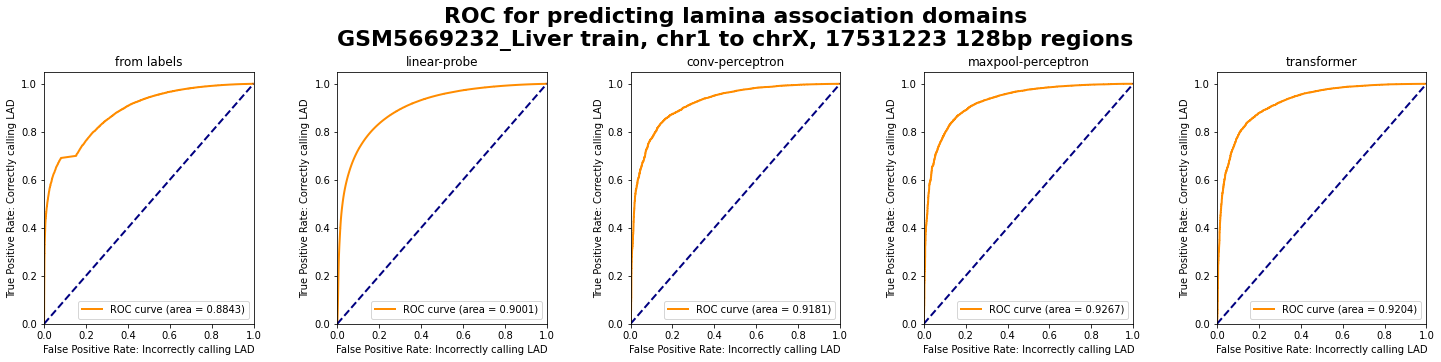

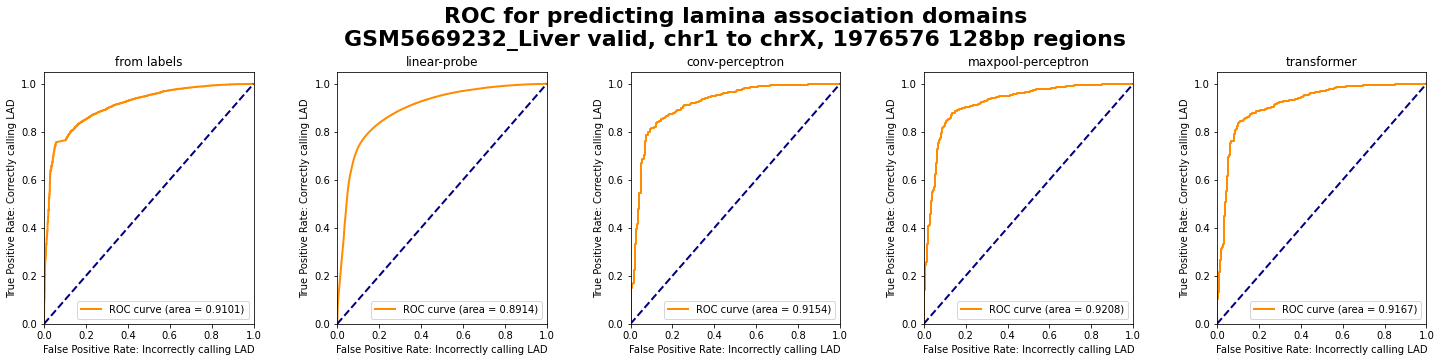

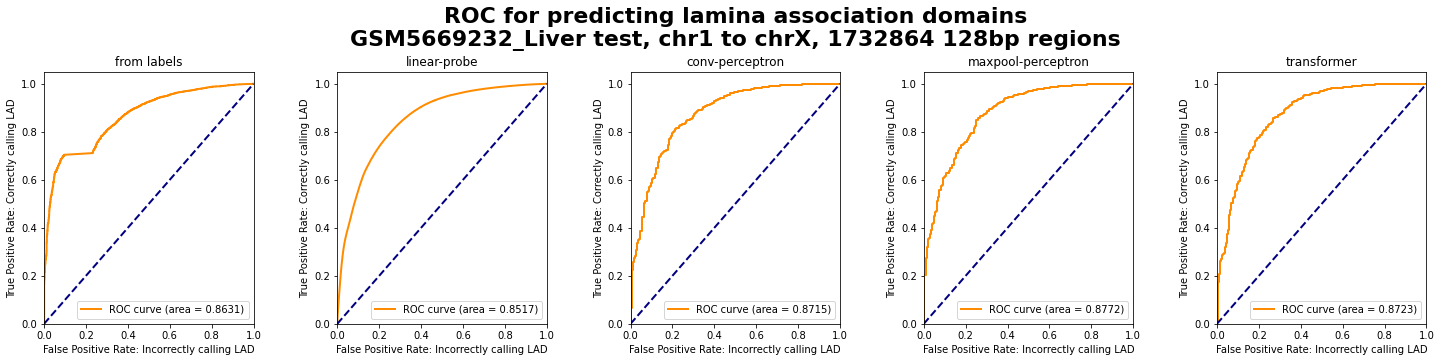

In [8]:
scaling_by_track = [1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/128,1/500,1/500,1/500,1,1/500,1]
data_label_by_track = ['(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(aligned read count)',
                       '(methylated adenines/adenines)',
                       '(methylated adenines/adenines)',
                       '(methylated CpGs/CpGs)',
                       '(CpGs count)',
                       '(methylated CpGs/CpGs)',
                       '(CpGs count)'
                      ]
for i,lads_array in [(0,cm_lads_array_concat),(9,fl_lads_array_concat)]:
    for subset_name,subset_label  in set_dict.items():
        nas_i = np.isnan(plot_array_low_res_concat[:,i])
        subset_mask = (test_train_split_array_concat==subset_label)
        regions_count = np.sum(subset_mask & ~nas_i)

        fig1, axs1 = plt.subplots(1,5,figsize=(24,5))
        fig1.suptitle(f'ROC for predicting lamina association domains\n{all_tracks[i]} {subset_name}, {plot_chroms[0]} to {plot_chroms[-1]}, {regions_count} 128bp regions',fontweight='bold',size=22)
        # Calculate ROC curve from labels
        fpr, tpr, thresholds = roc_curve(lads_array[subset_mask]>0,np.nan_to_num(plot_array_high_res_concat[subset_mask,0]))
        roc_auc = auc(fpr, tpr)
        axs1[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = %0.4f)' % roc_auc)
        axs1[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs1[0].set_xlim([0.0, 1.0])
        axs1[0].set_ylim([0.0, 1.05])
        axs1[0].set_xlabel('False Positive Rate: Incorrectly calling LAD')
        axs1[0].set_ylabel('True Positive Rate: Correctly calling LAD')
        axs1[0].set_title(f'from labels')    
        axs1[0].legend(loc="lower right")

        for indx,(key,output_array) in enumerate(output_arrays_concat.items()):
            fpr, tpr, thresholds = roc_curve(lads_array[subset_mask]>0,np.nan_to_num(output_array[subset_mask,0]))
            roc_auc = auc(fpr, tpr)

            axs1[indx+1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
            axs1[indx+1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            axs1[indx+1].set_xlim([0.0, 1.0])
            axs1[indx+1].set_ylim([0.0, 1.05])
            axs1[indx+1].set_xlabel('False Positive Rate: Incorrectly calling LAD')
            axs1[indx+1].set_ylabel('True Positive Rate: Correctly calling LAD')
            axs1[indx+1].set_title(f'{key}')
            axs1[indx+1].legend(loc="lower right")
        fig1.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, hspace=0.5, wspace=0.4)
        plt.show()

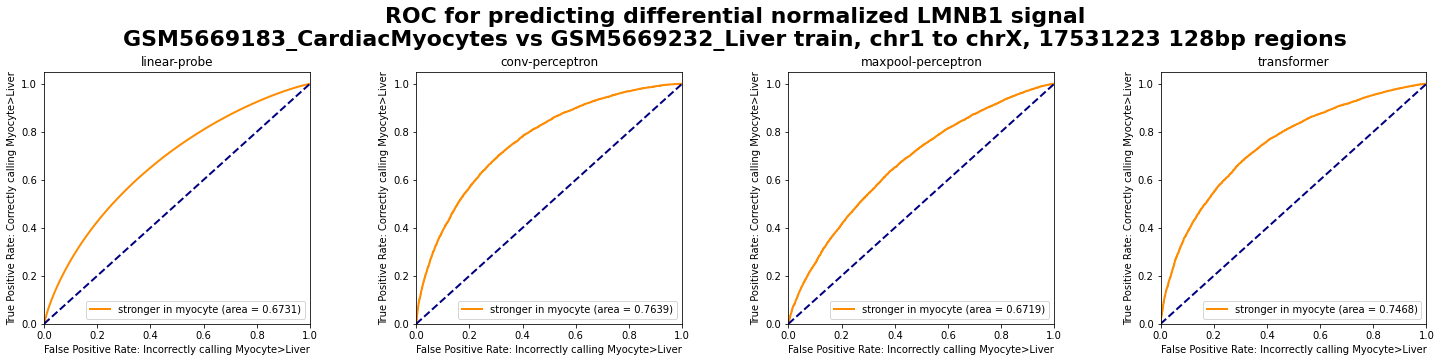

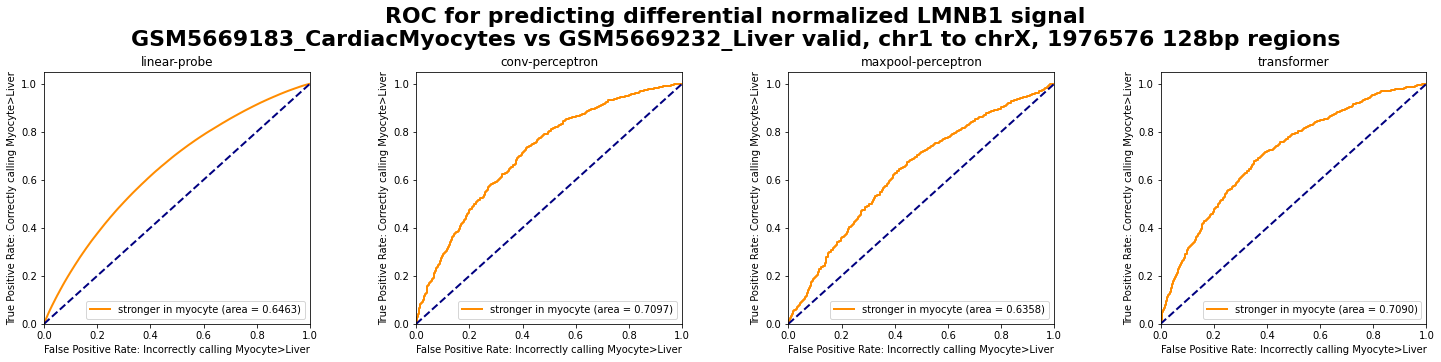

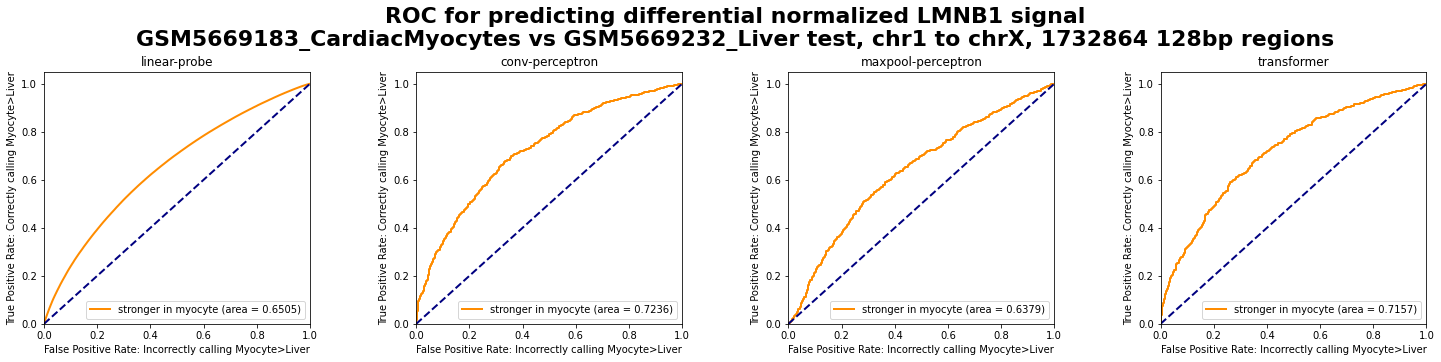

In [9]:
for subset_name,subset_label  in set_dict.items():
    nas_i = np.isnan(plot_array_low_res_concat[:,0])
    subset_mask = (test_train_split_array_concat==subset_label)
    regions_count = np.sum(subset_mask & ~nas_i)
    fig1, axs1 = plt.subplots(1,4,figsize=(24,5))
    fig1.suptitle(f'ROC for predicting differential normalized LMNB1 signal\n{all_tracks[0]} vs {all_tracks[9]} {subset_name}, {plot_chroms[0]} to {plot_chroms[-1]}, {regions_count} 128bp regions',fontweight='bold',size=22)
    mean_cm = np.nanmean(plot_array_low_res_concat[:,0])
    std_cm = np.nanstd(plot_array_low_res_concat[:,0])
    mean_fl = np.nanmean(plot_array_low_res_concat[:,9])
    std_fl = np.nanstd(plot_array_low_res_concat[:,9])

    meas_differences = ((plot_array_low_res_concat[:,9]-mean_fl)/std_fl-(plot_array_low_res_concat[:,0]-mean_cm)/std_cm)
    
    for indx,(key,output_array) in enumerate(output_arrays_concat.items()):
        pred_differences = ((output_array[:,9]-mean_fl)/std_fl-(output_array[:,0]-mean_cm)/std_cm)
        fpr1, tpr1, thresholds1 = roc_curve(np.nan_to_num(meas_differences>0)[subset_mask],np.nan_to_num(pred_differences[subset_mask]))
        roc_auc1 = auc(fpr1, tpr1)
        axs1[indx].plot(fpr1, tpr1, color='darkorange', lw=2, label=f'stronger in myocyte (area = %0.4f)' % roc_auc1)
        axs1[indx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs1[indx].set_xlim([0.0, 1.0])
        axs1[indx].set_ylim([0.0, 1.05])
        axs1[indx].set_xlabel('False Positive Rate: Incorrectly calling Myocyte>Liver')
        axs1[indx].set_ylabel('True Positive Rate: Correctly calling Myocyte>Liver')
        axs1[indx].set_title(f'{key}')    
        axs1[indx].legend(loc="lower right")   
    fig1.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, hspace=0.5, wspace=0.4)
    plt.show()

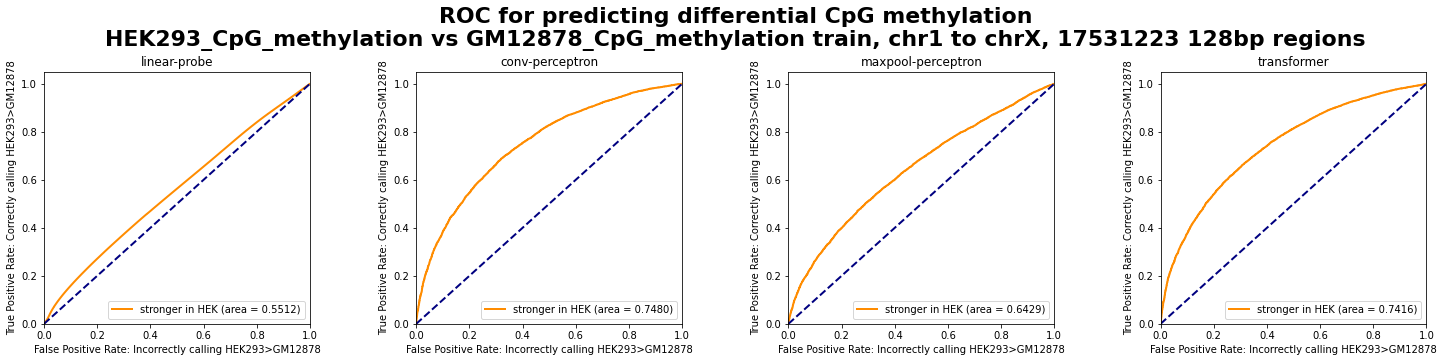

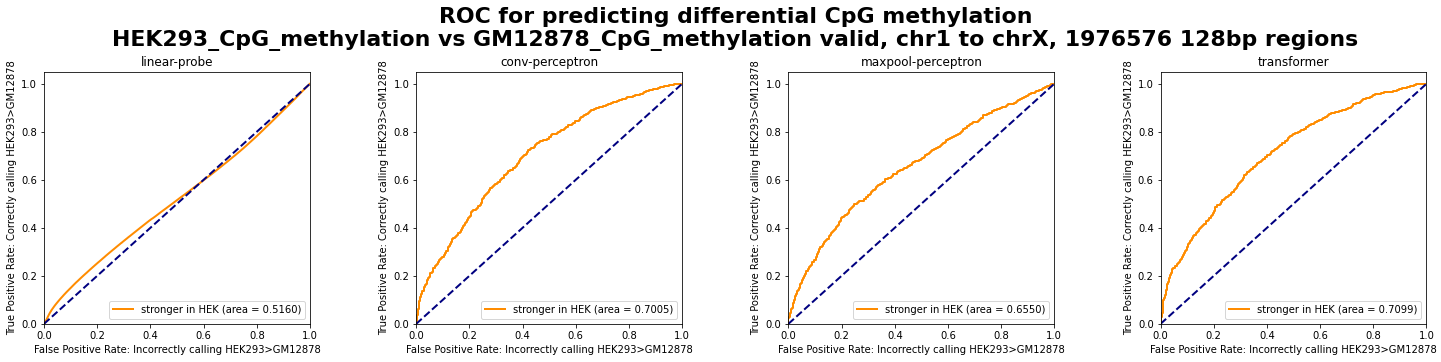

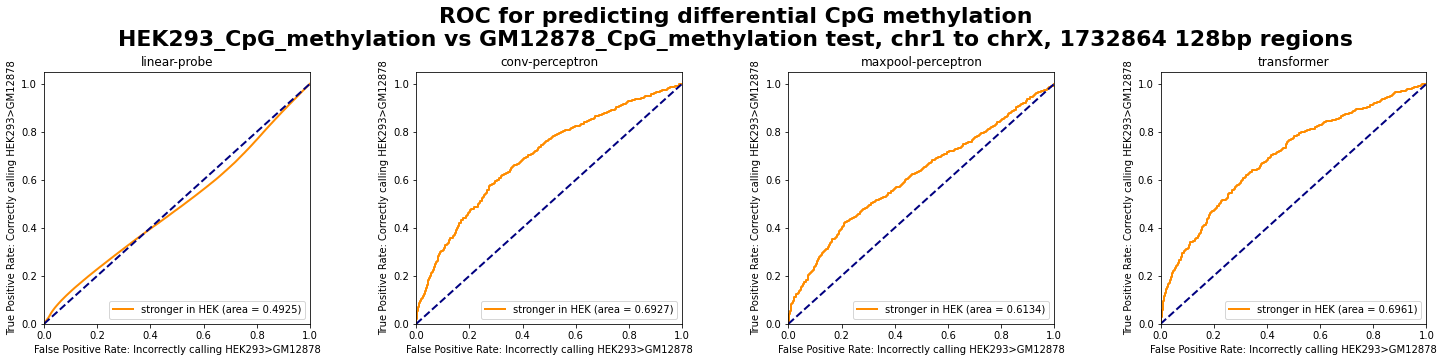

In [10]:
for subset_name,subset_label  in set_dict.items():
    nas_i = np.isnan(plot_array_low_res_concat[:,0])
    subset_mask = (test_train_split_array_concat==subset_label)
    regions_count = np.sum(subset_mask & ~nas_i)
    fig1, axs1 = plt.subplots(1,4,figsize=(24,5))
    fig1.suptitle(f'ROC for predicting differential CpG methylation\n{all_tracks[14]} vs {all_tracks[16]} {subset_name}, {plot_chroms[0]} to {plot_chroms[-1]}, {regions_count} 128bp regions',fontweight='bold',size=22)

    meas_differences = plot_array_low_res_concat[:,14]-plot_array_low_res_concat[:,16]
    
    for indx,(key,output_array) in enumerate(output_arrays_concat.items()):
        pred_differences = output_array[:,14]-output_array[:,16]
        fpr1, tpr1, thresholds1 = roc_curve(np.nan_to_num(meas_differences>0)[subset_mask],np.nan_to_num(pred_differences[subset_mask]))
        roc_auc1 = auc(fpr1, tpr1)
        axs1[indx].plot(fpr1, tpr1, color='darkorange', lw=2, label=f'stronger in HEK (area = %0.4f)' % roc_auc1)
        axs1[indx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs1[indx].set_xlim([0.0, 1.0])
        axs1[indx].set_ylim([0.0, 1.05])
        axs1[indx].set_xlabel('False Positive Rate: Incorrectly calling HEK293>GM12878')
        axs1[indx].set_ylabel('True Positive Rate: Correctly calling HEK293>GM12878')
        axs1[indx].set_title(f'{key}')    
        axs1[indx].legend(loc="lower right")   
    fig1.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, hspace=0.5, wspace=0.4)
    plt.show()

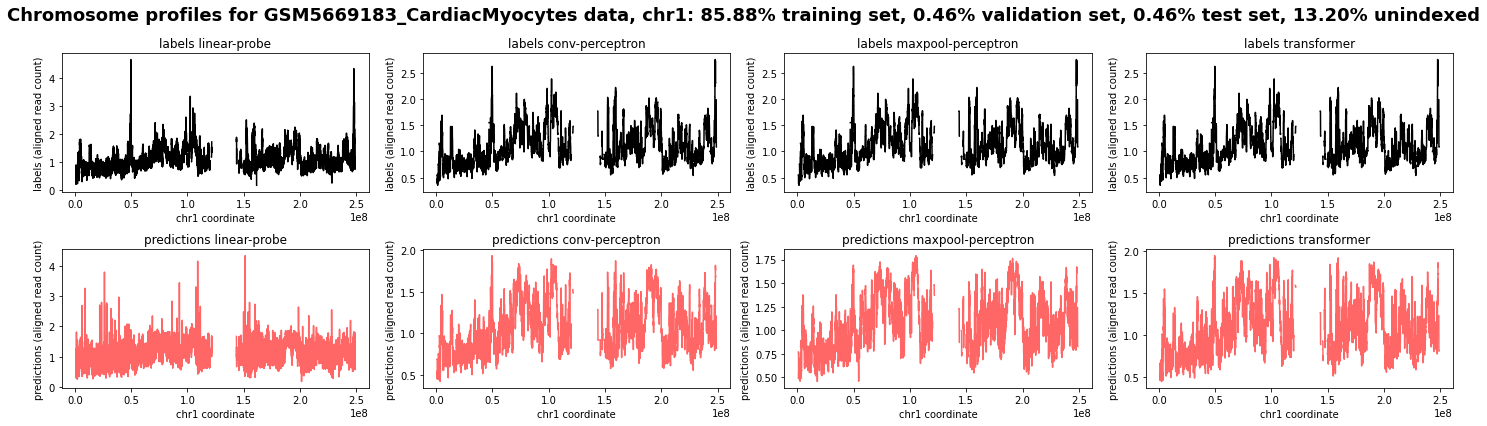

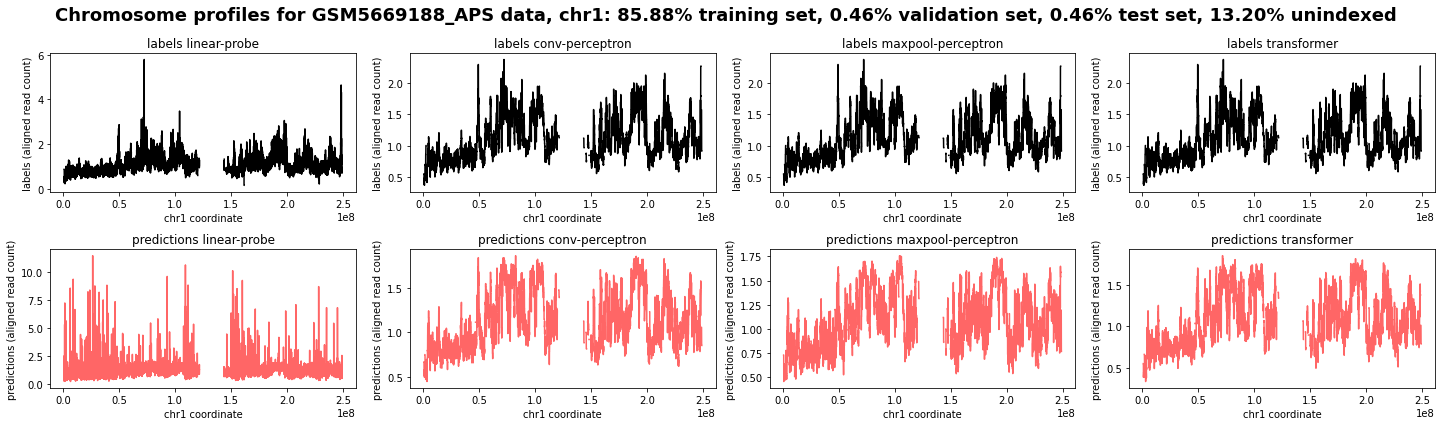

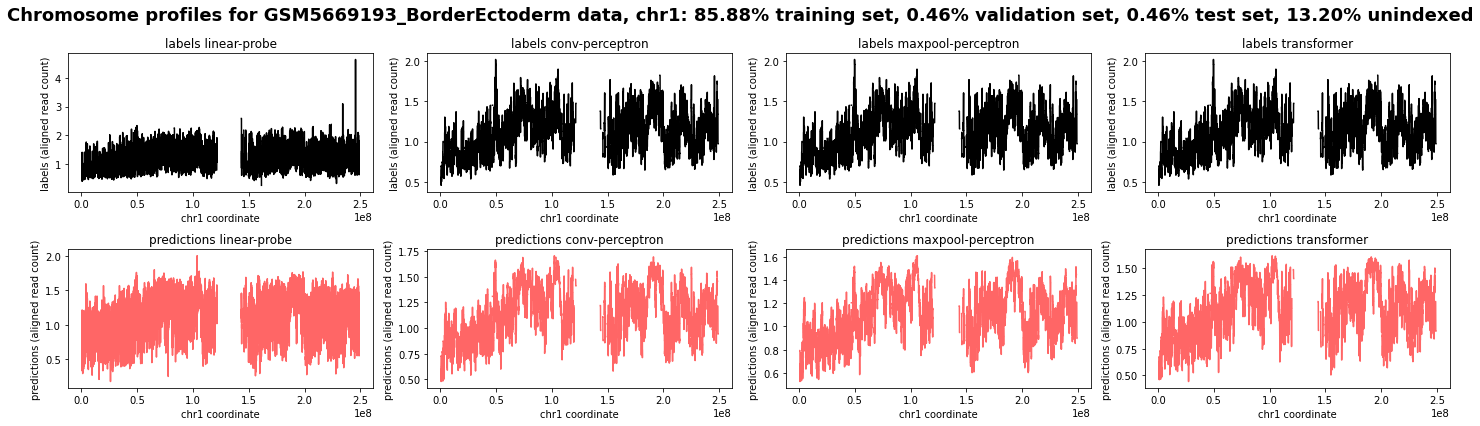

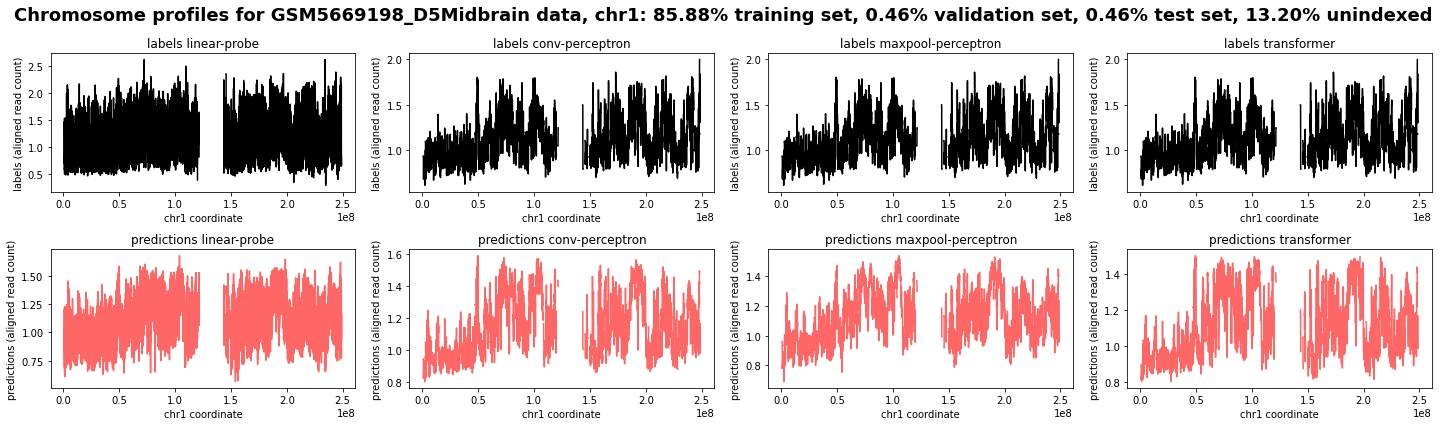

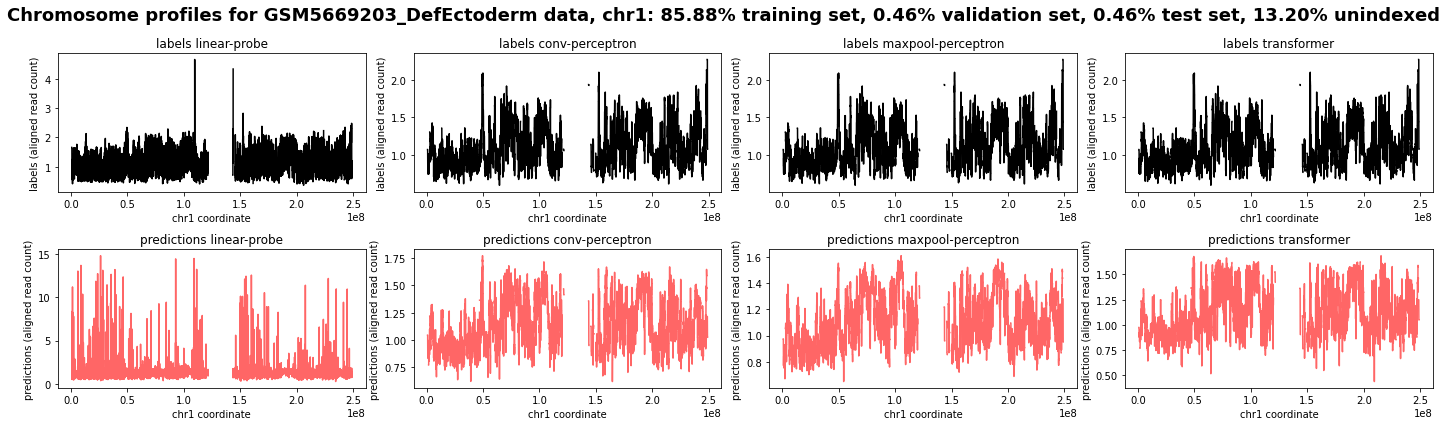

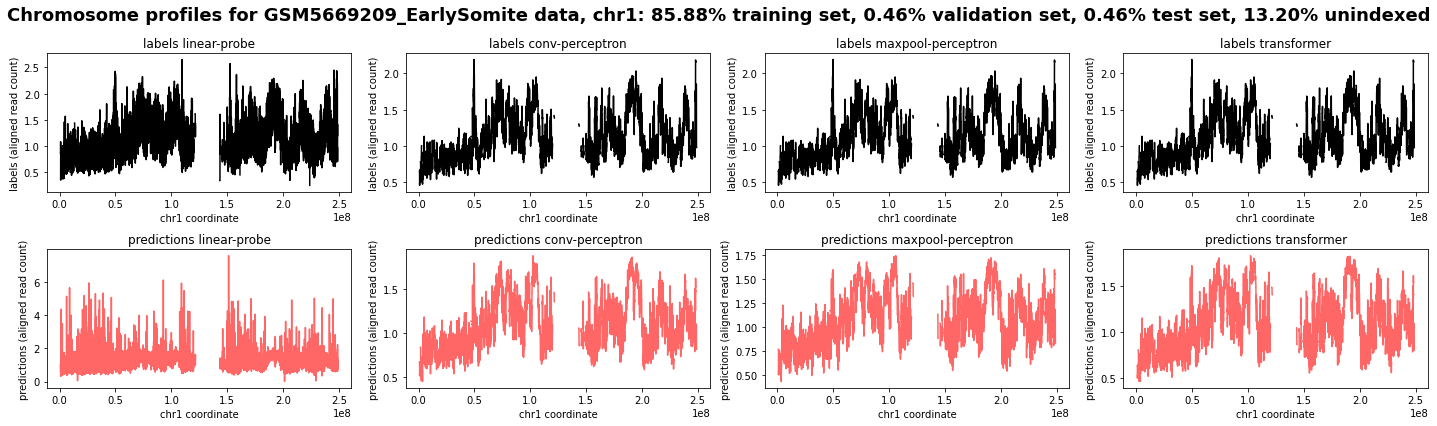

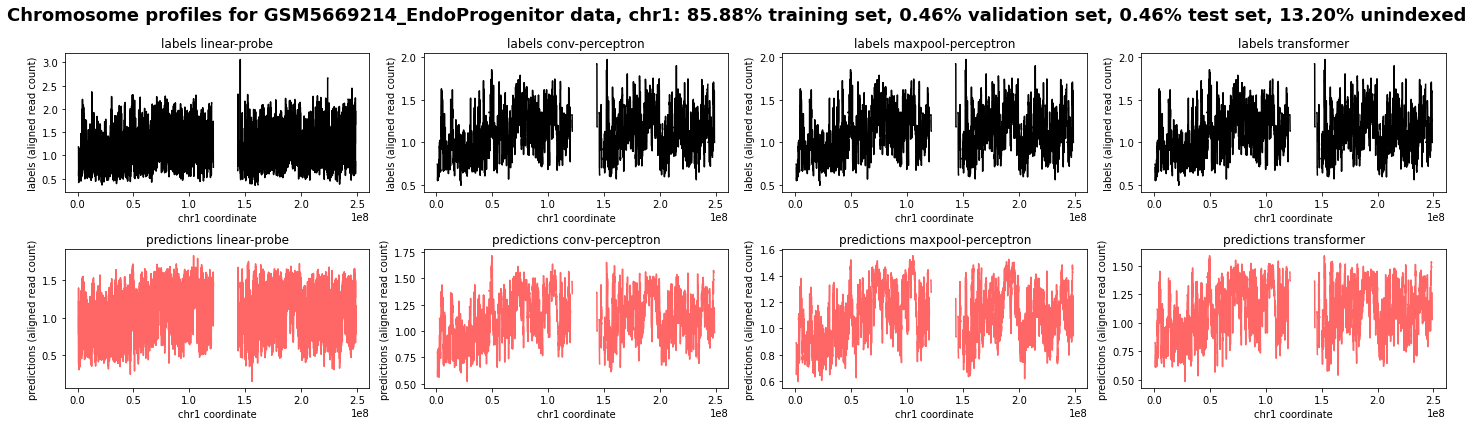

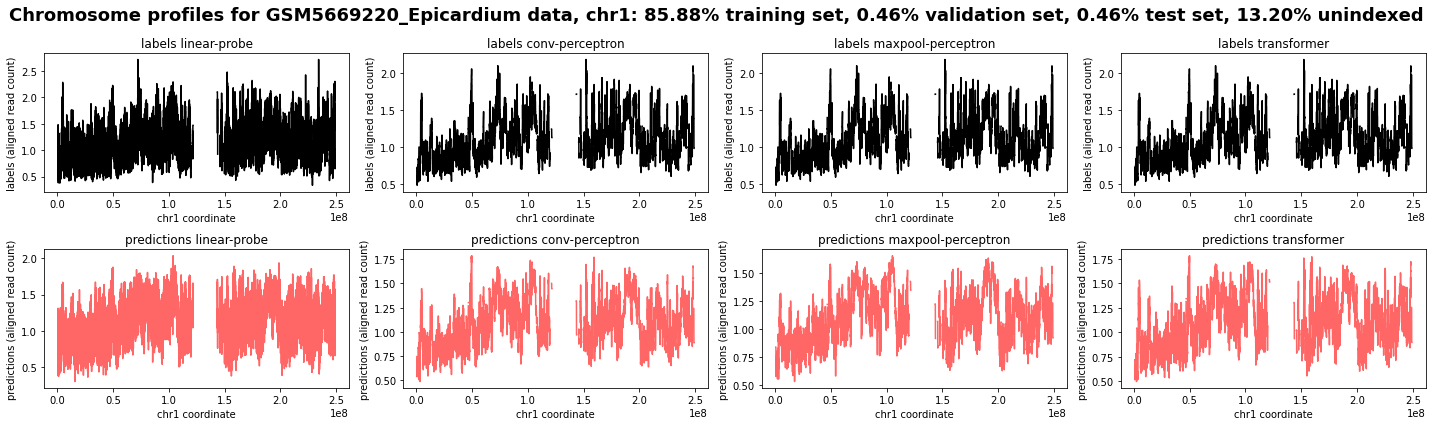

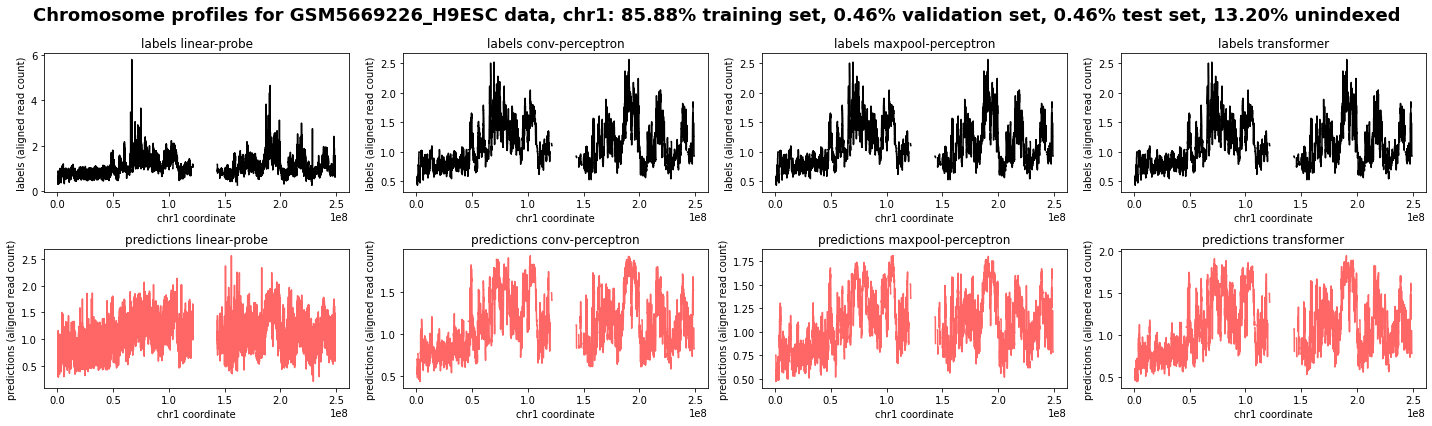

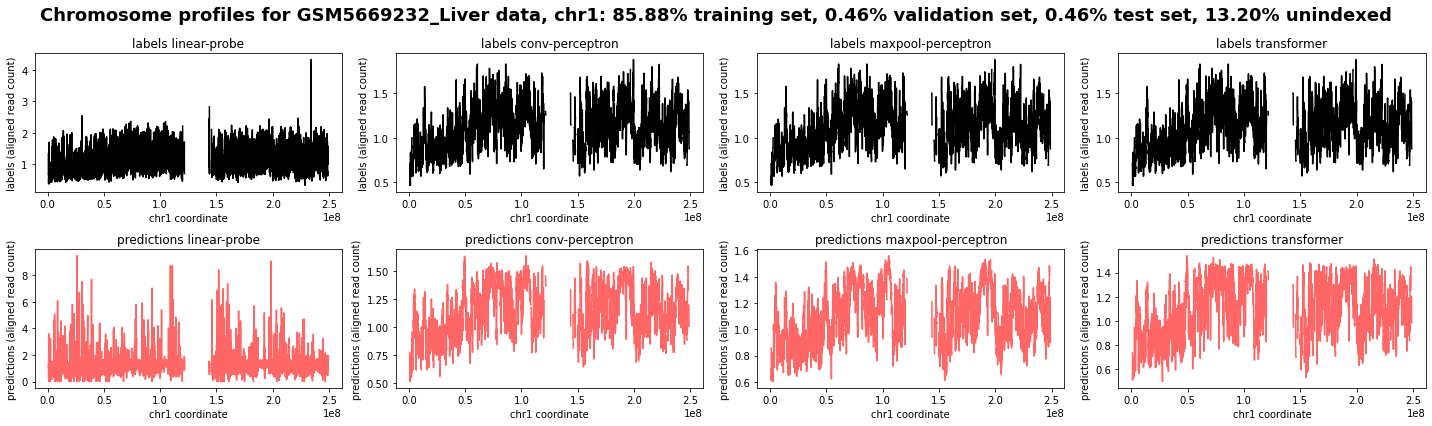

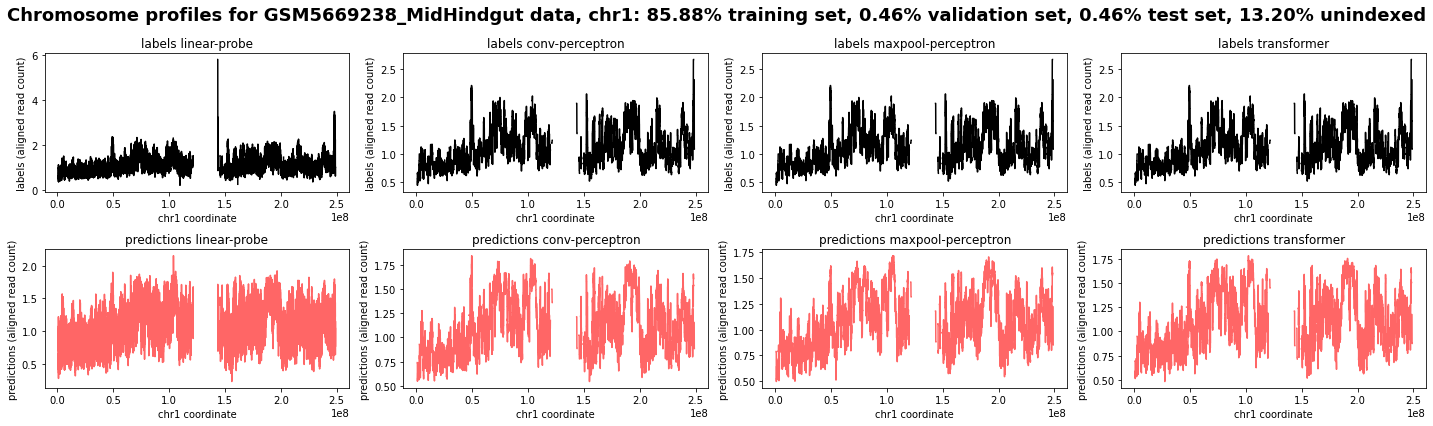

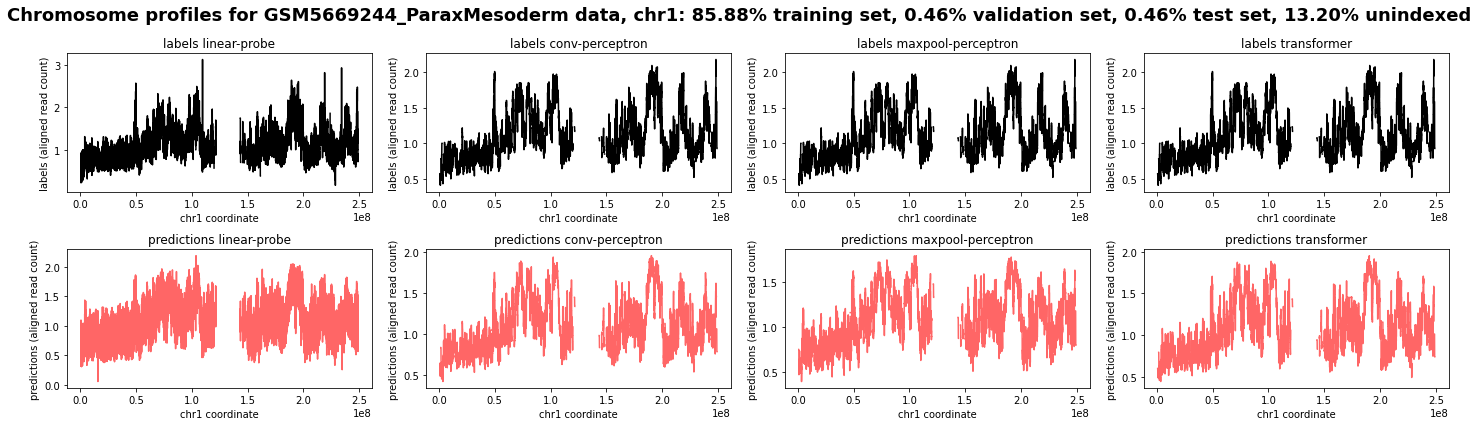

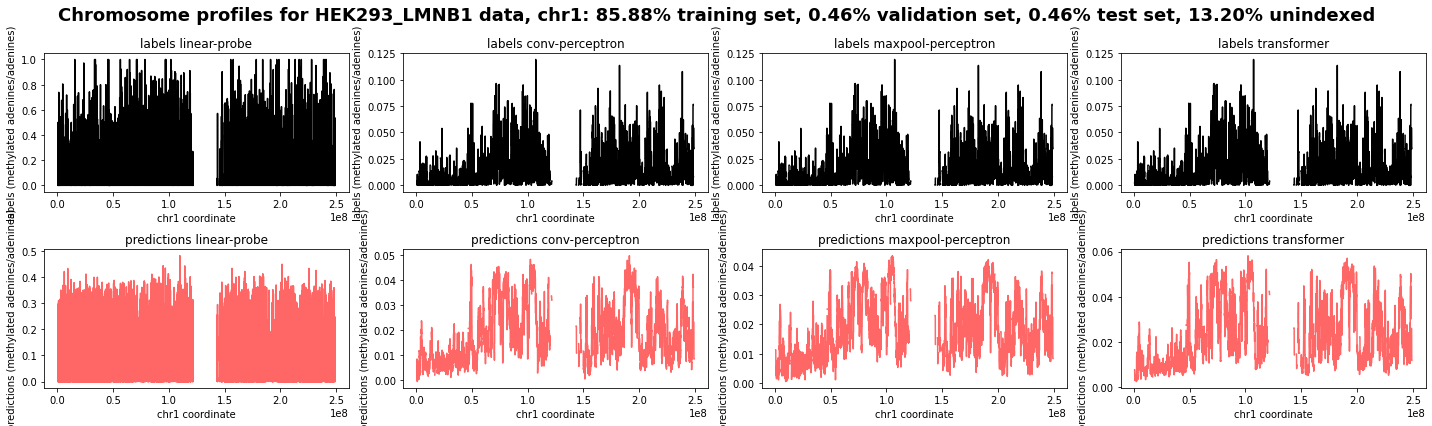

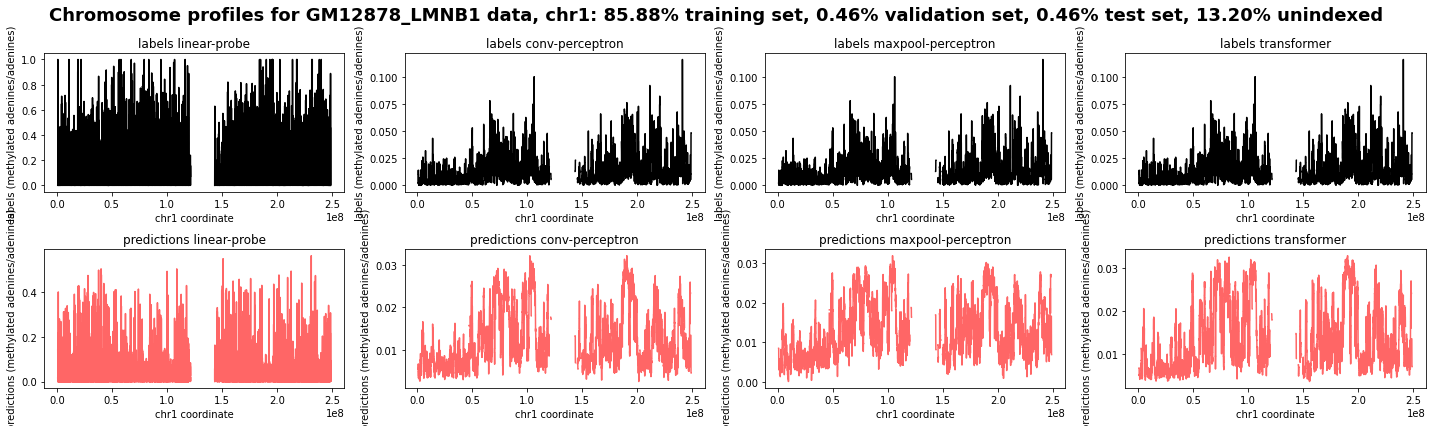

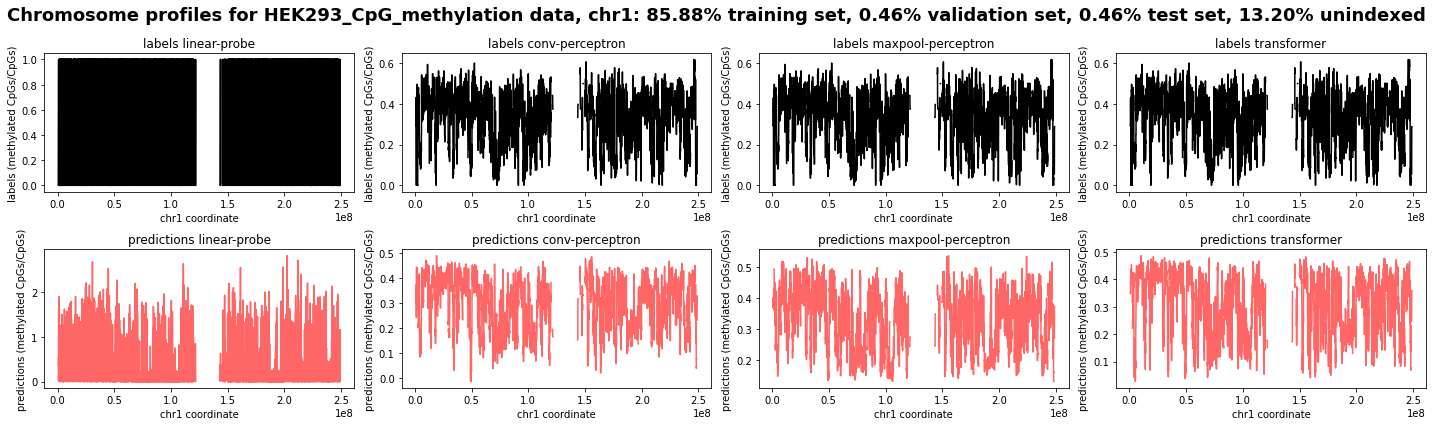

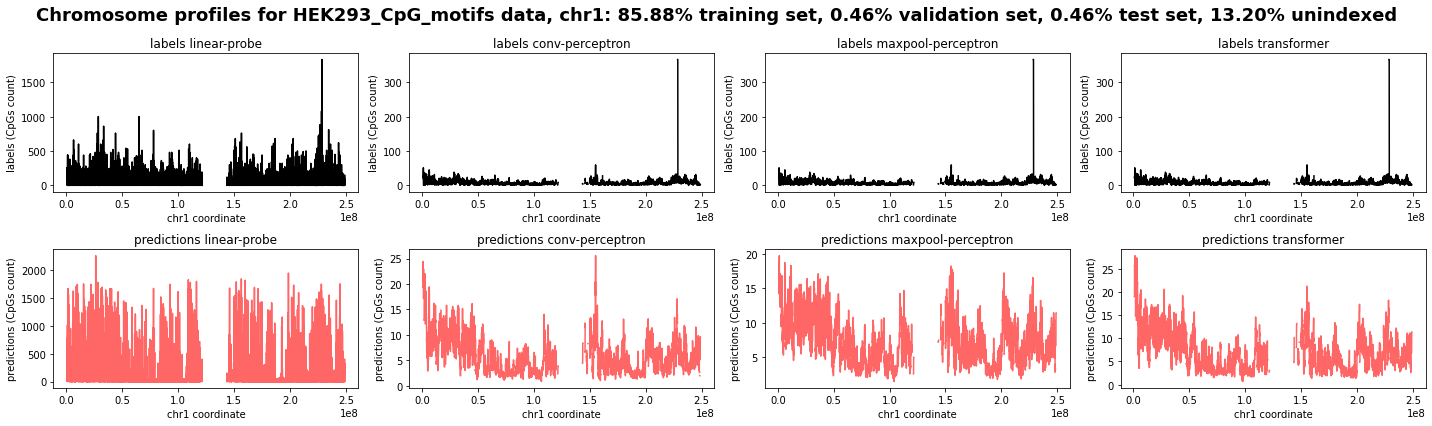

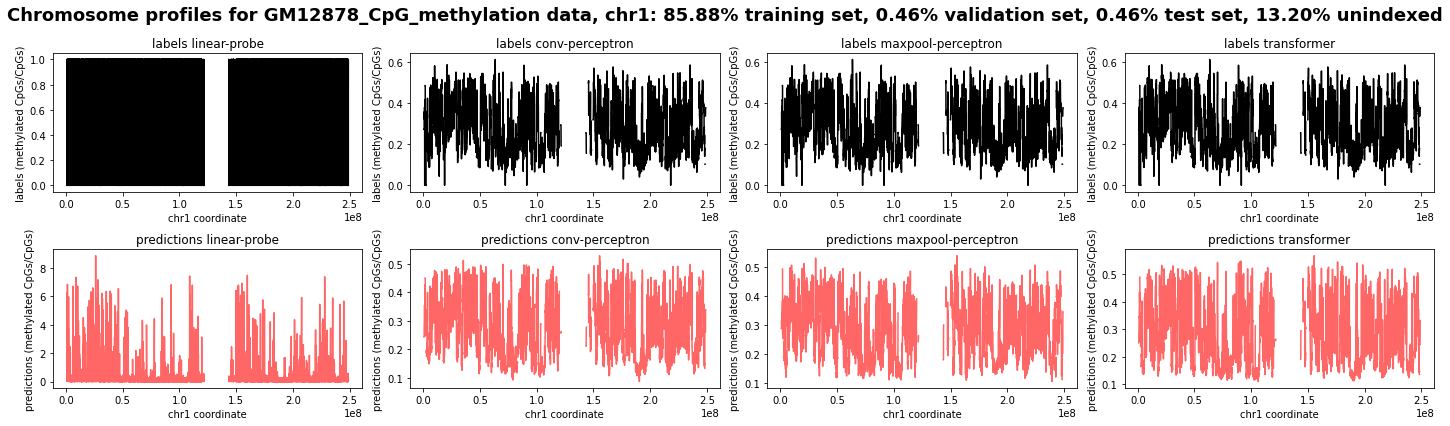

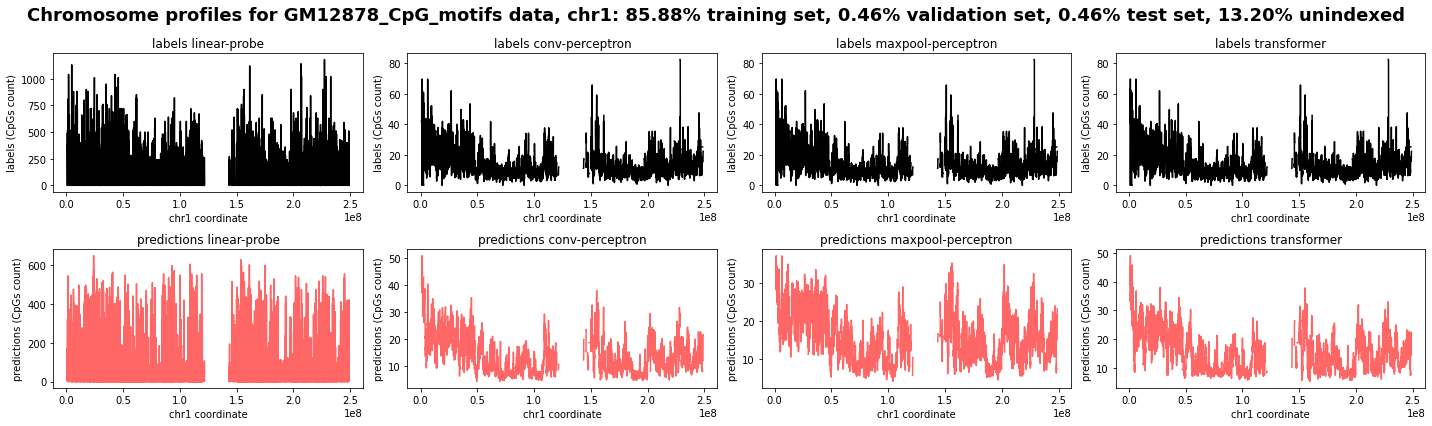

skipping chr2 to make notebook small enough to view!
skipping chr3 to make notebook small enough to view!
skipping chr4 to make notebook small enough to view!
skipping chr5 to make notebook small enough to view!
skipping chr6 to make notebook small enough to view!
skipping chr7 to make notebook small enough to view!
skipping chr8 to make notebook small enough to view!
skipping chr9 to make notebook small enough to view!
skipping chr10 to make notebook small enough to view!
skipping chr11 to make notebook small enough to view!
skipping chr12 to make notebook small enough to view!
skipping chr13 to make notebook small enough to view!


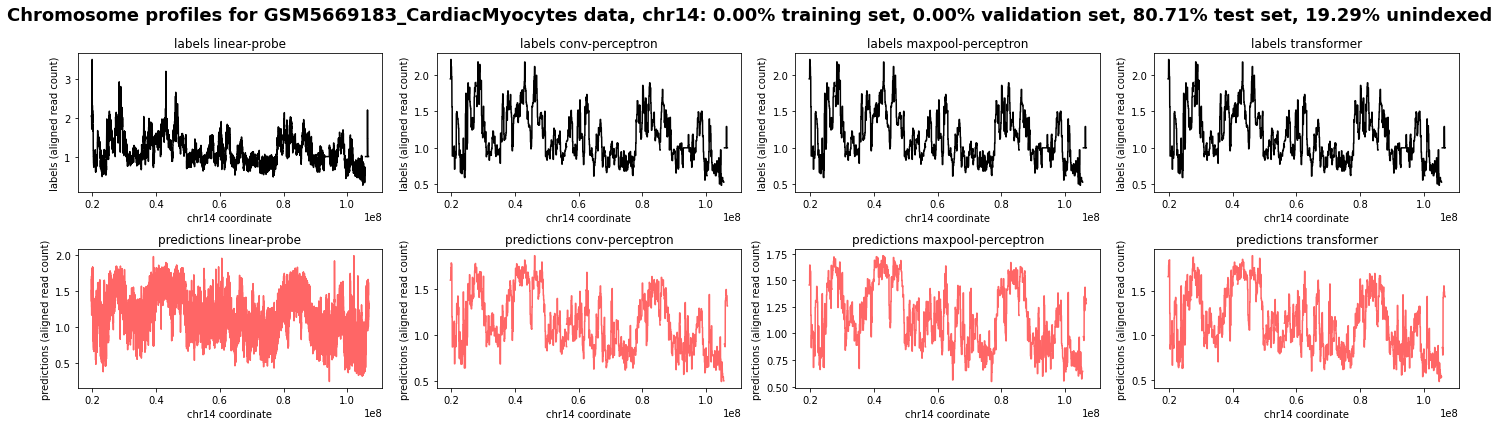

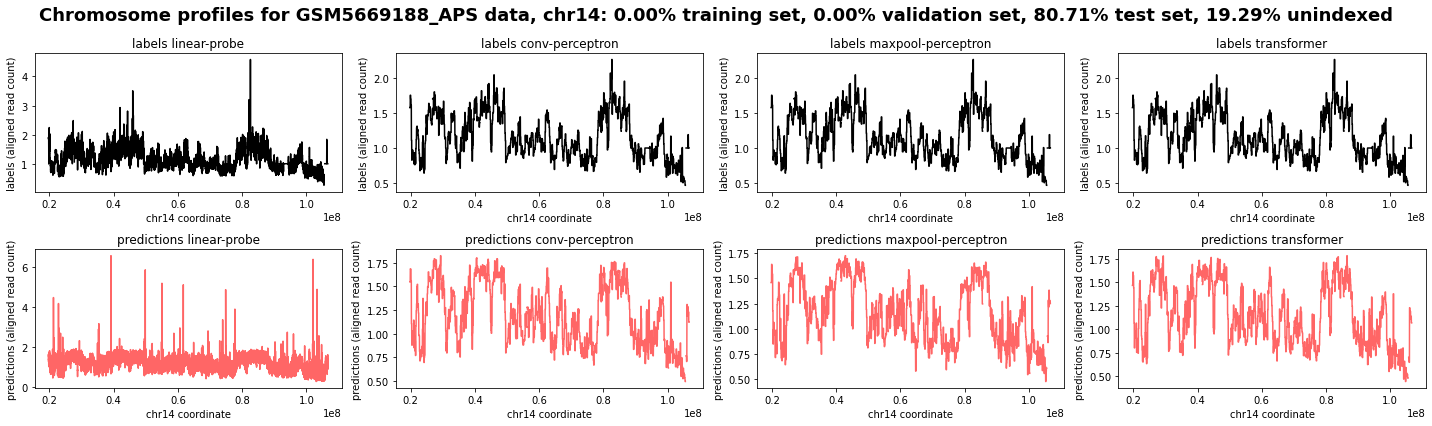

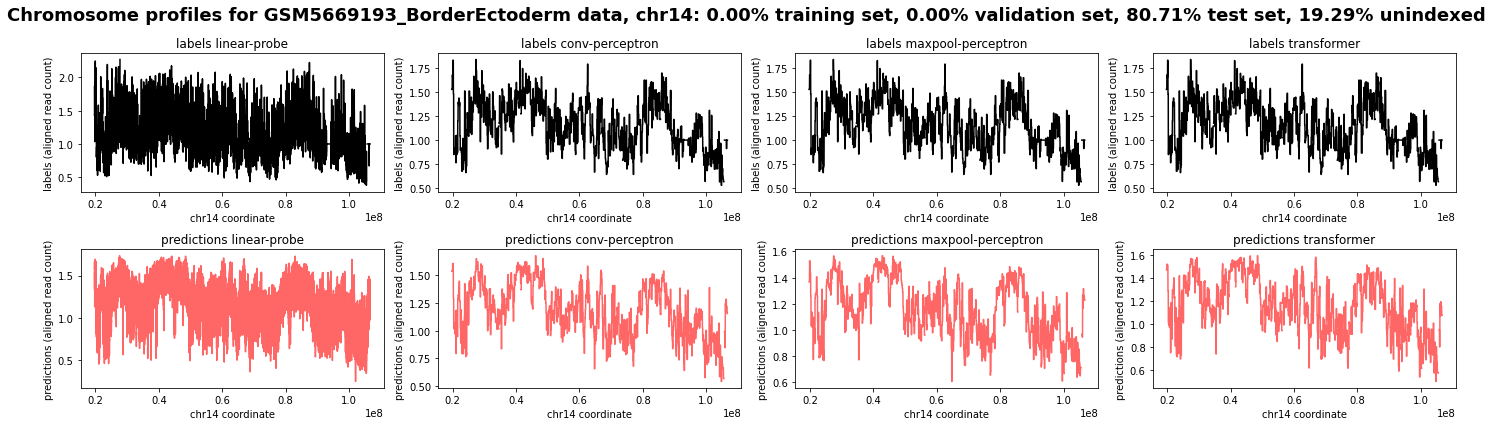

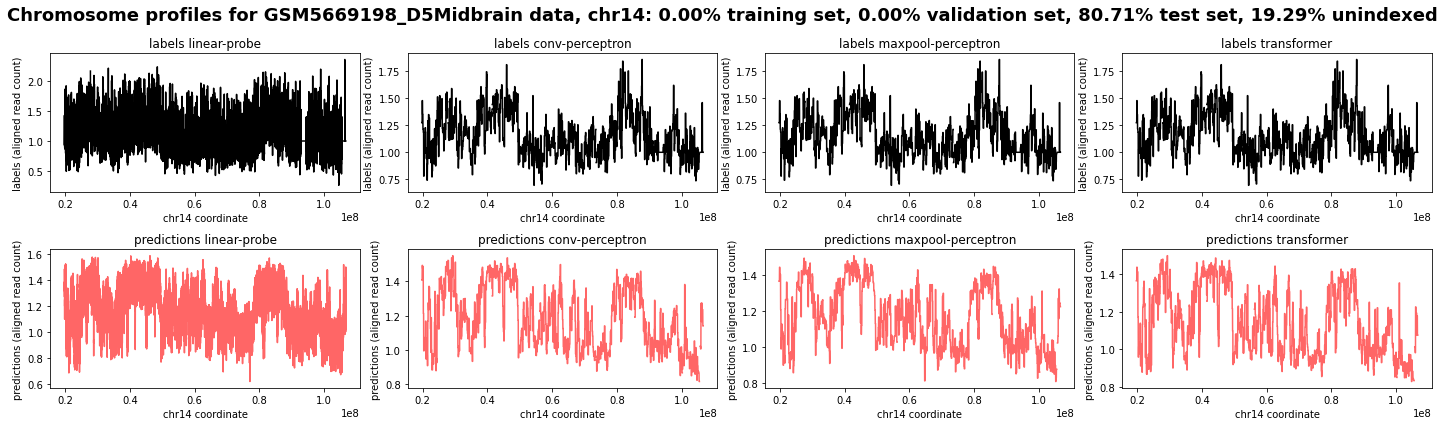

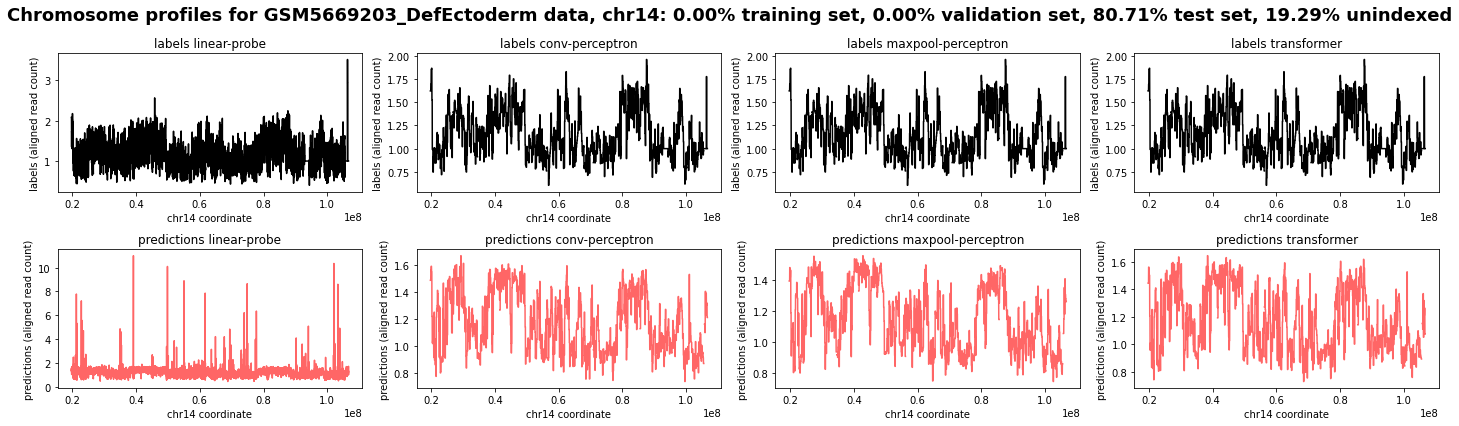

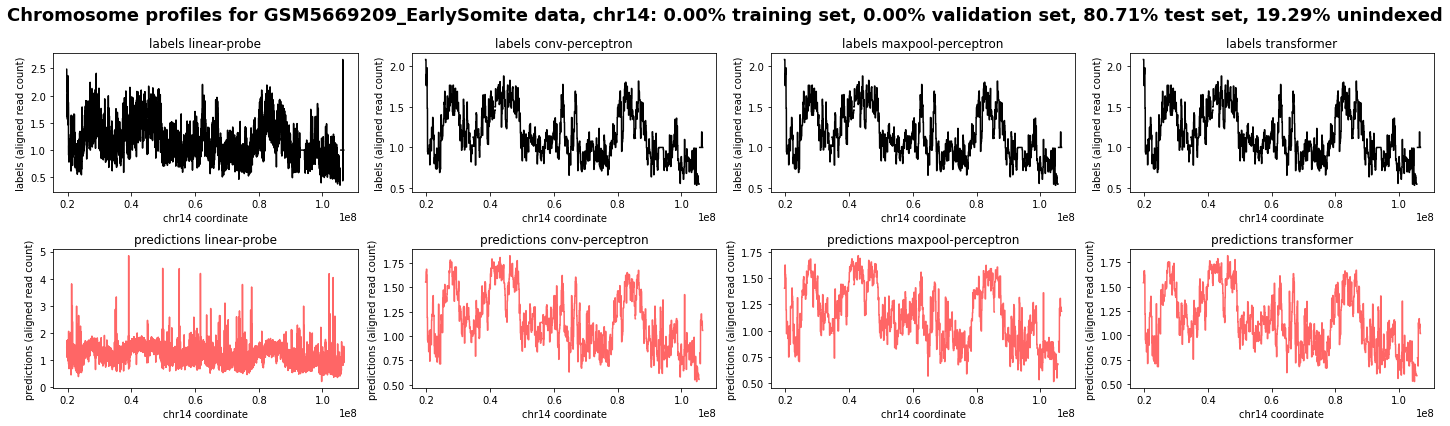

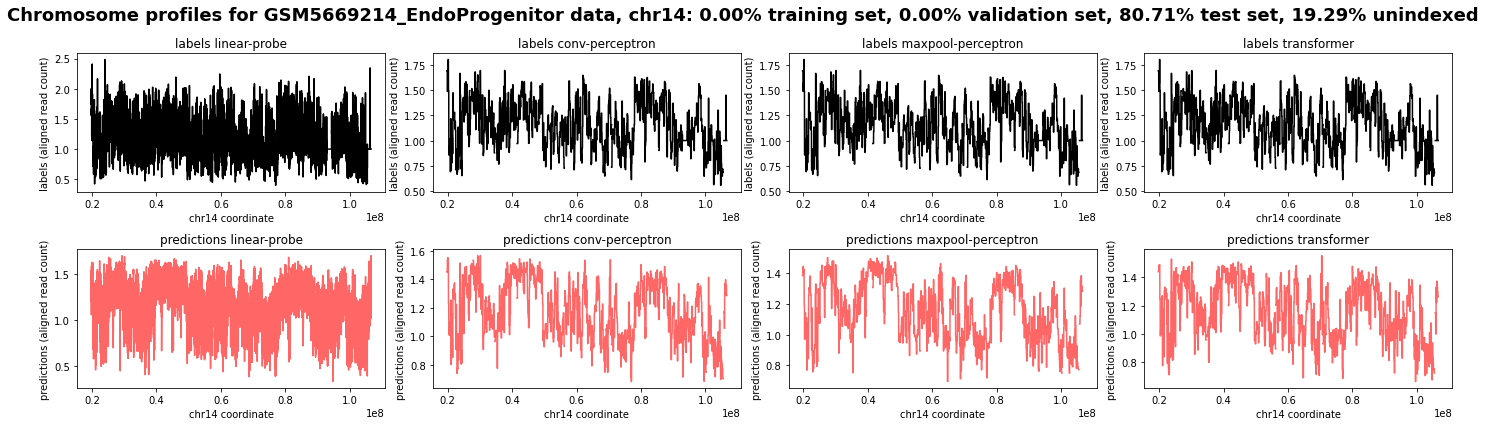

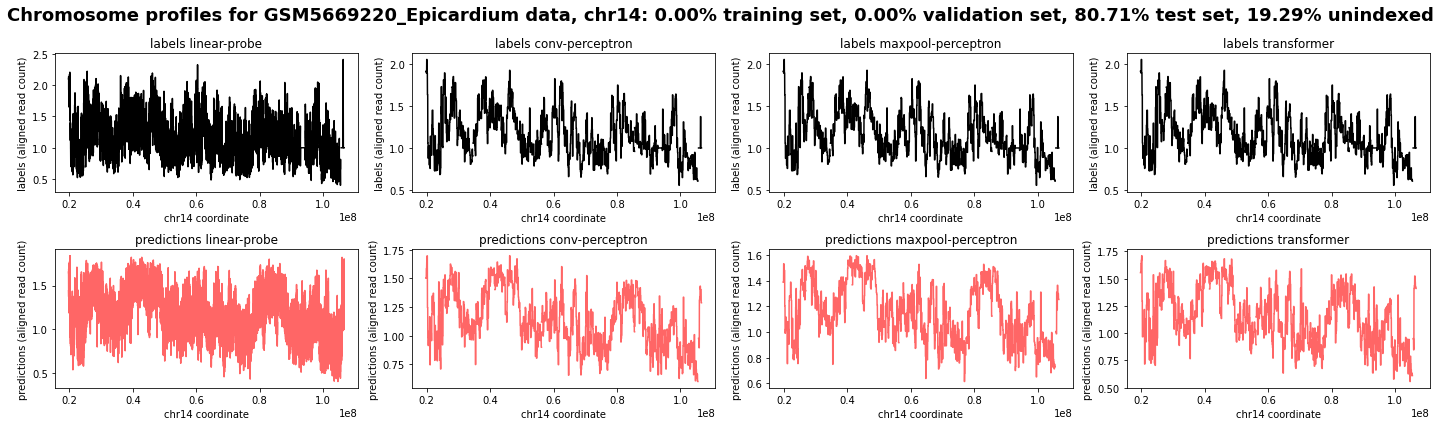

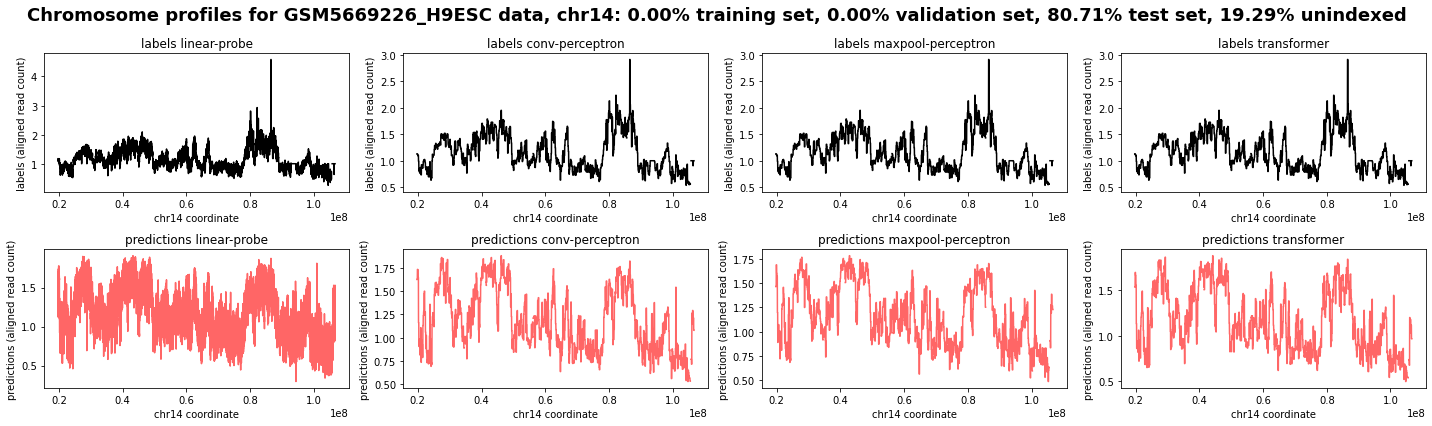

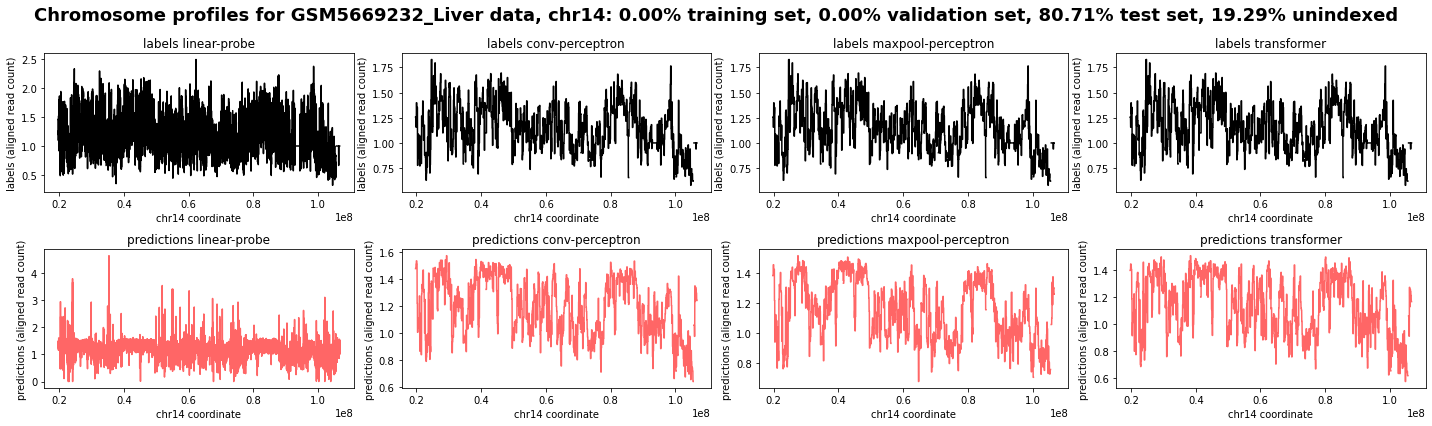

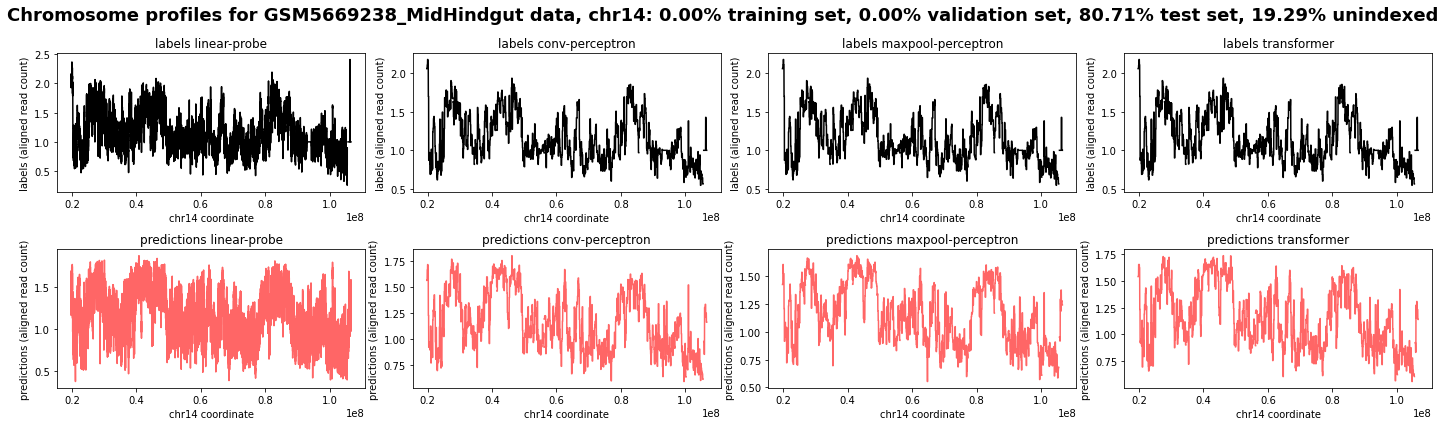

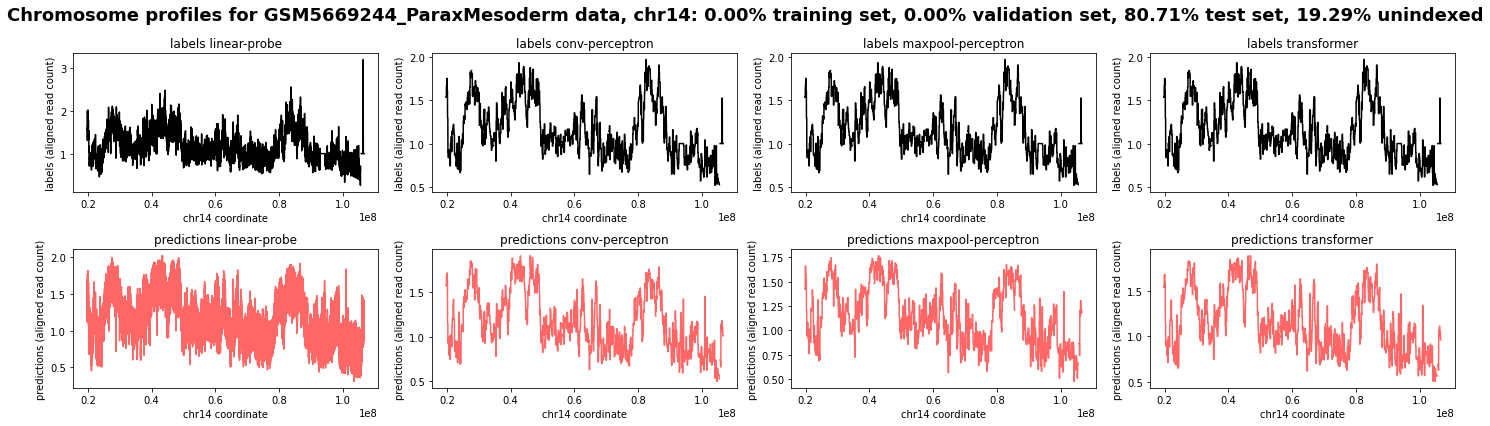

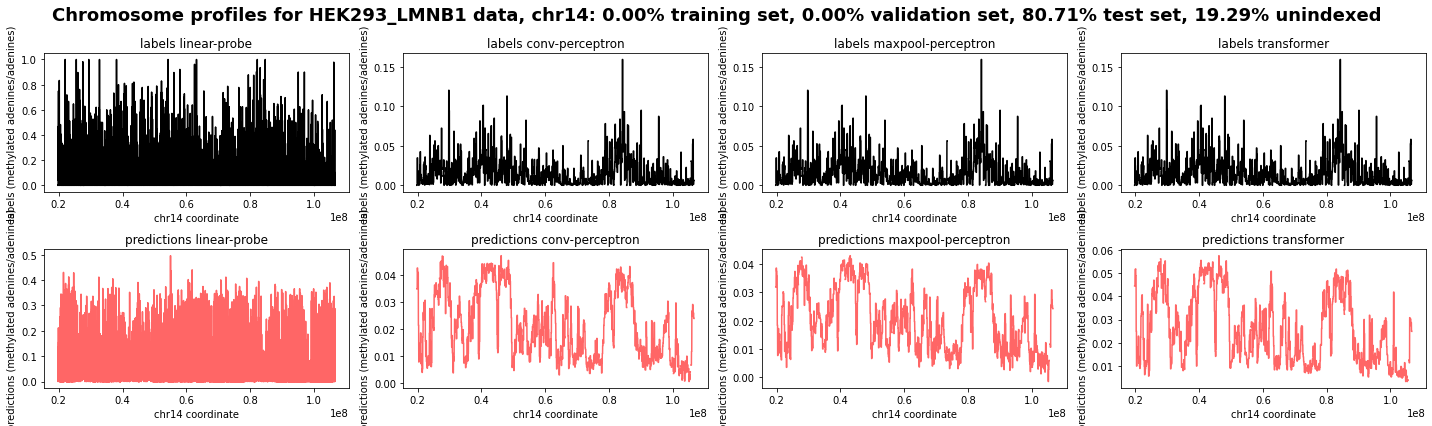

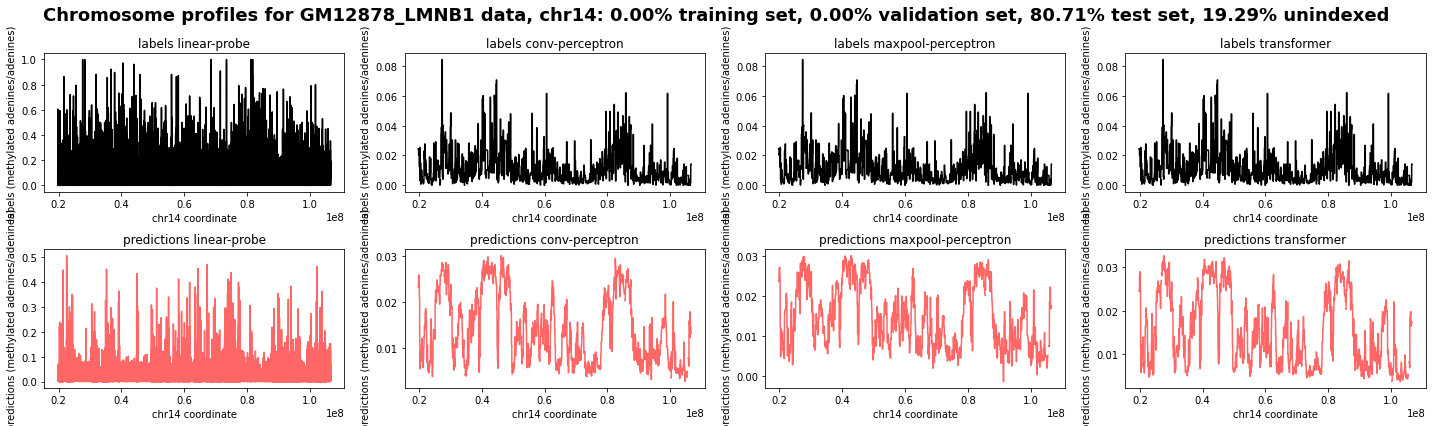

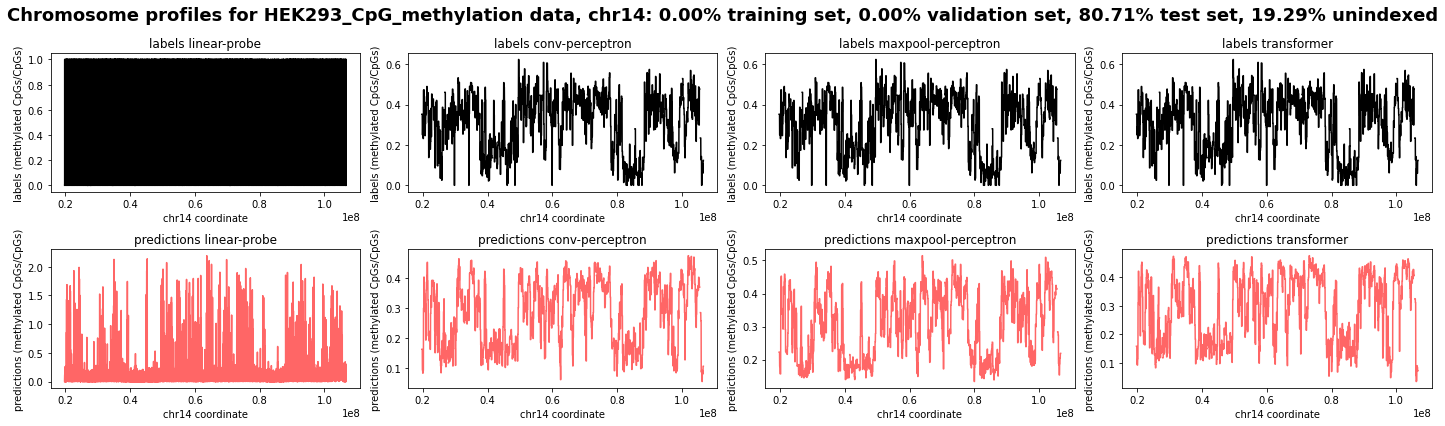

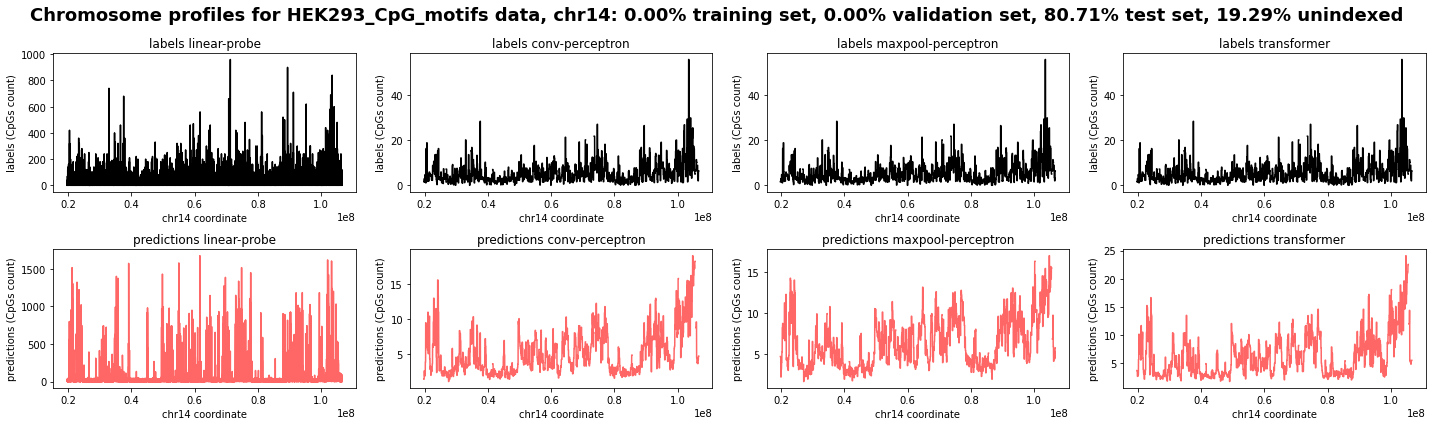

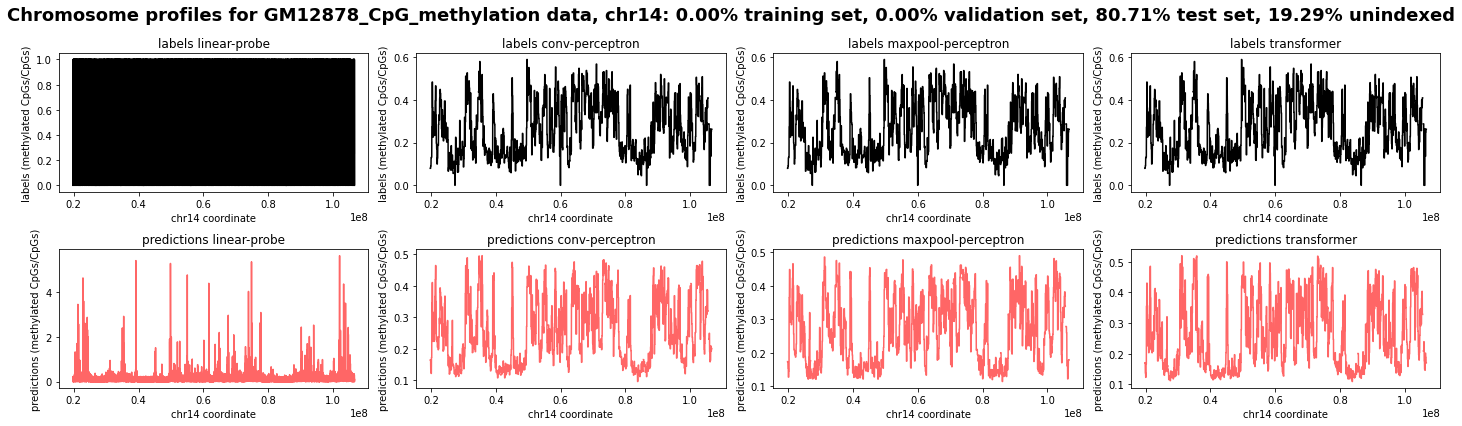

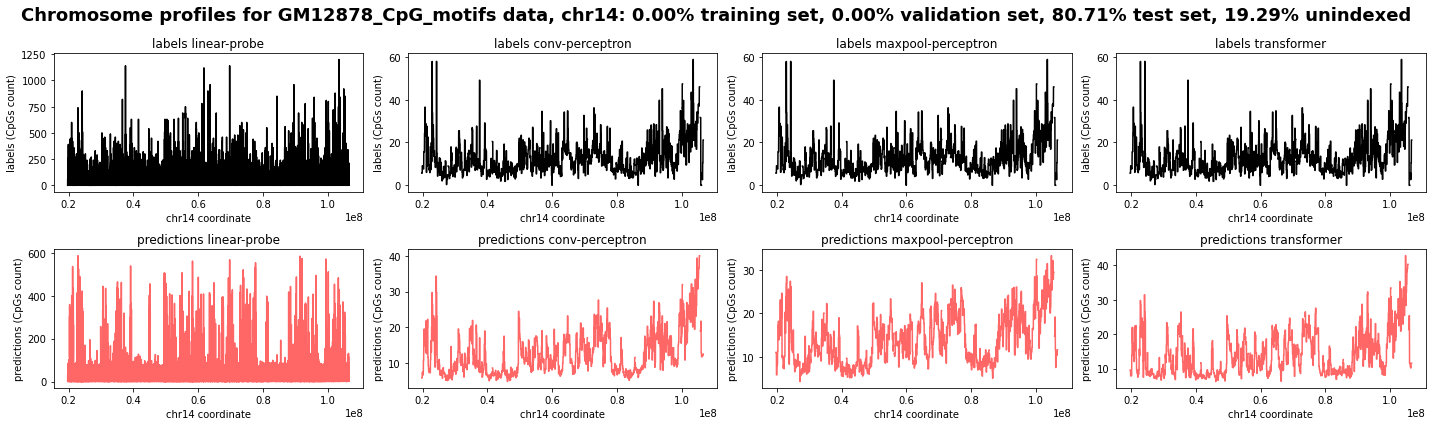

skipping chr15 to make notebook small enough to view!
skipping chr16 to make notebook small enough to view!
skipping chr17 to make notebook small enough to view!
skipping chr18 to make notebook small enough to view!
skipping chr19 to make notebook small enough to view!
skipping chr20 to make notebook small enough to view!
skipping chr21 to make notebook small enough to view!
skipping chr22 to make notebook small enough to view!


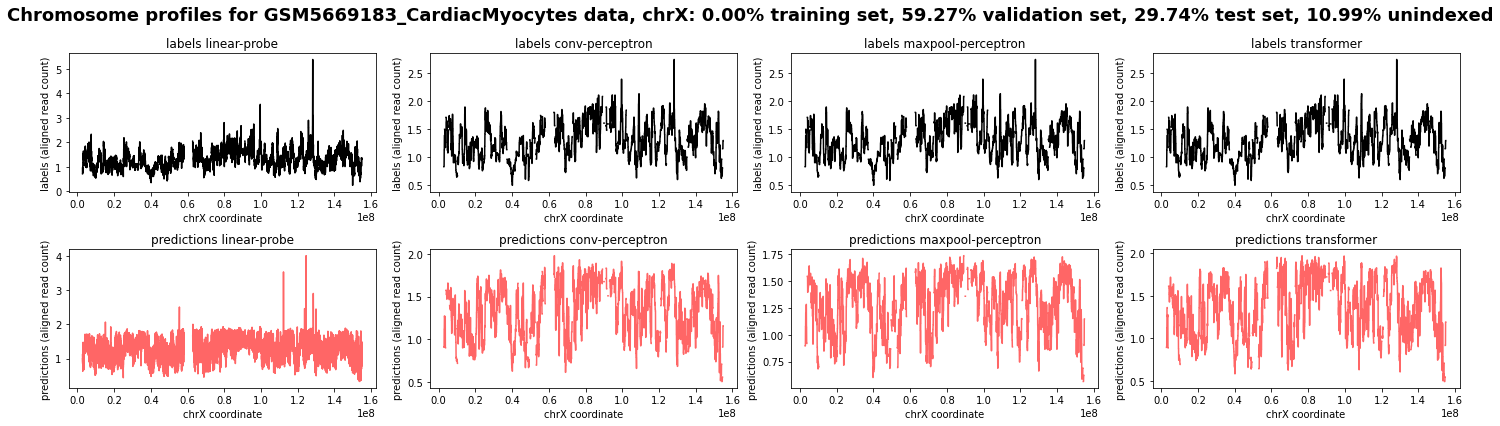

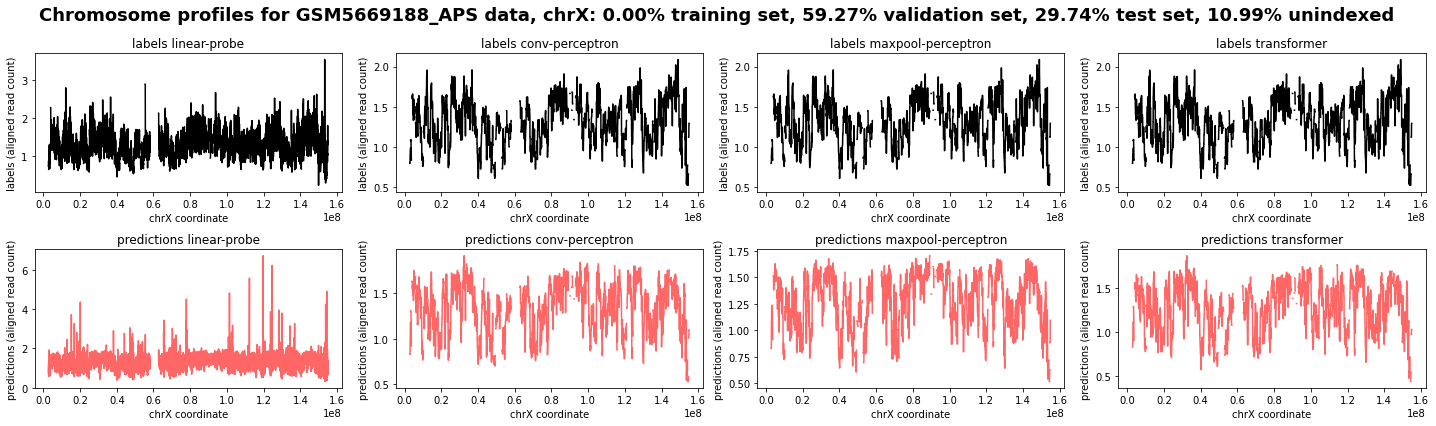

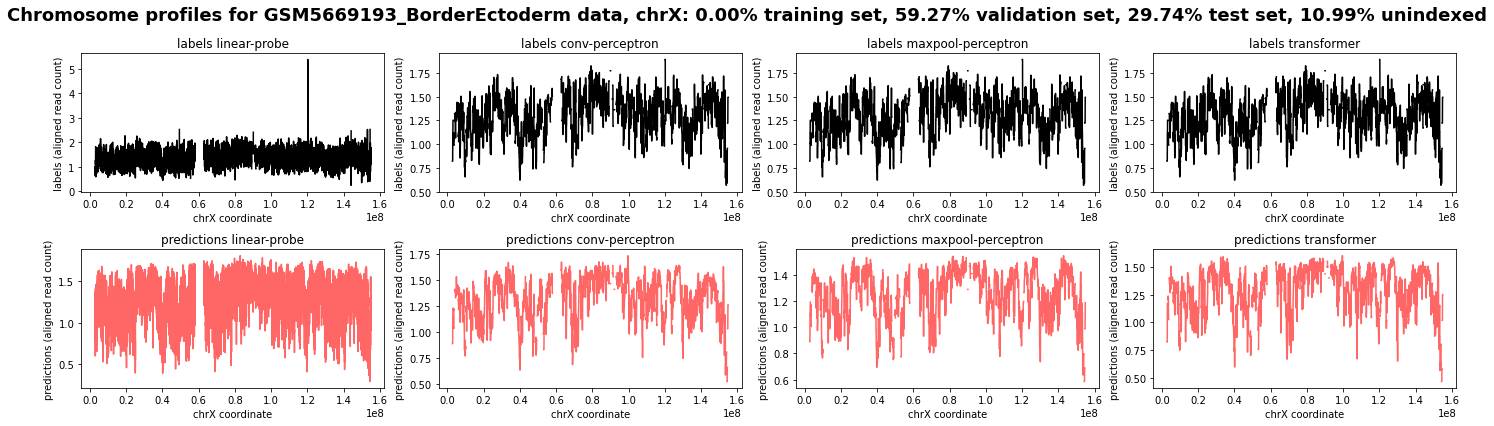

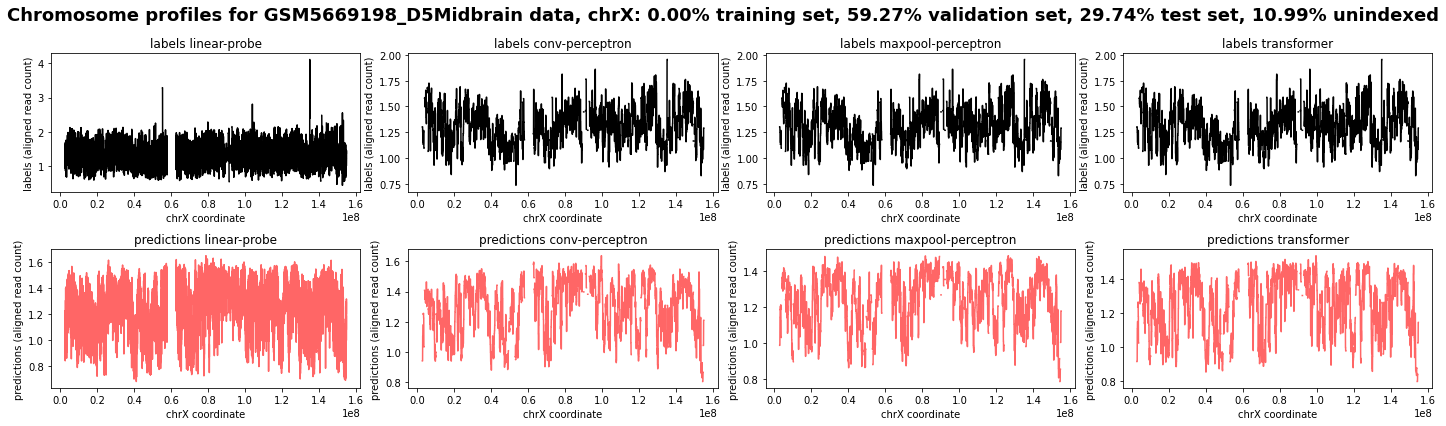

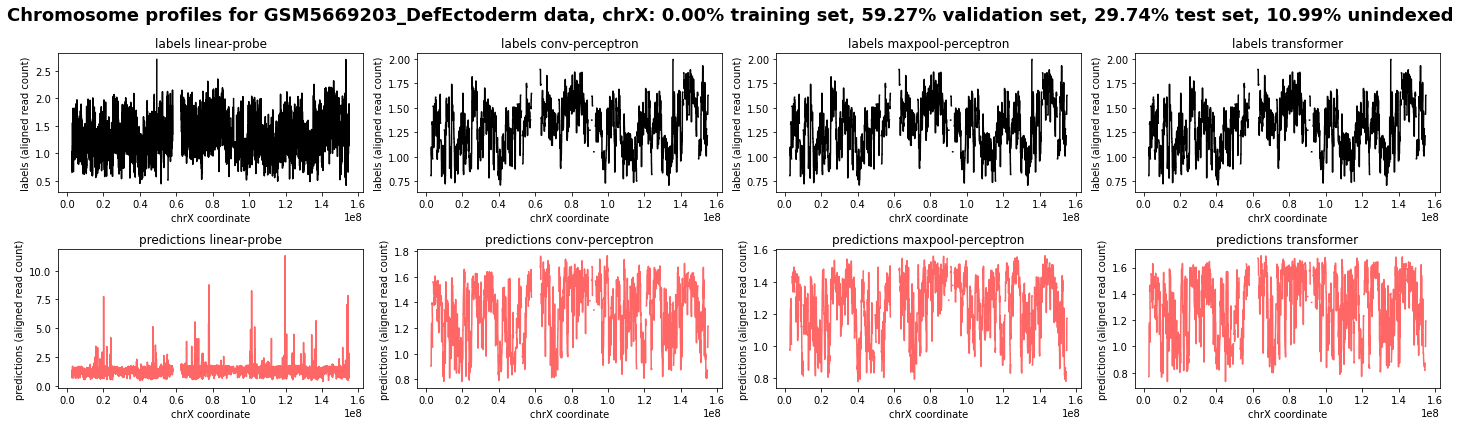

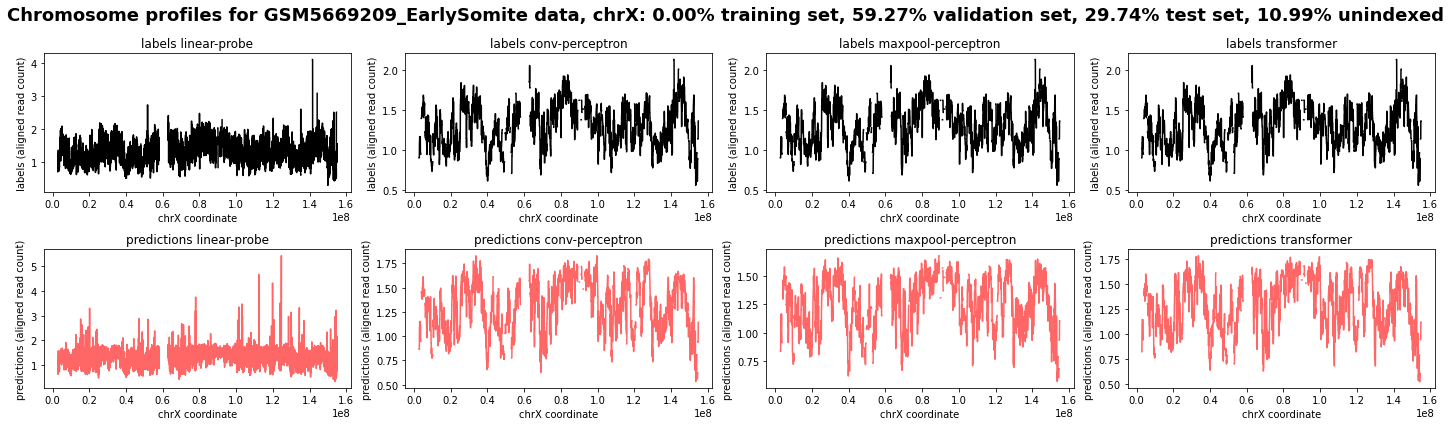

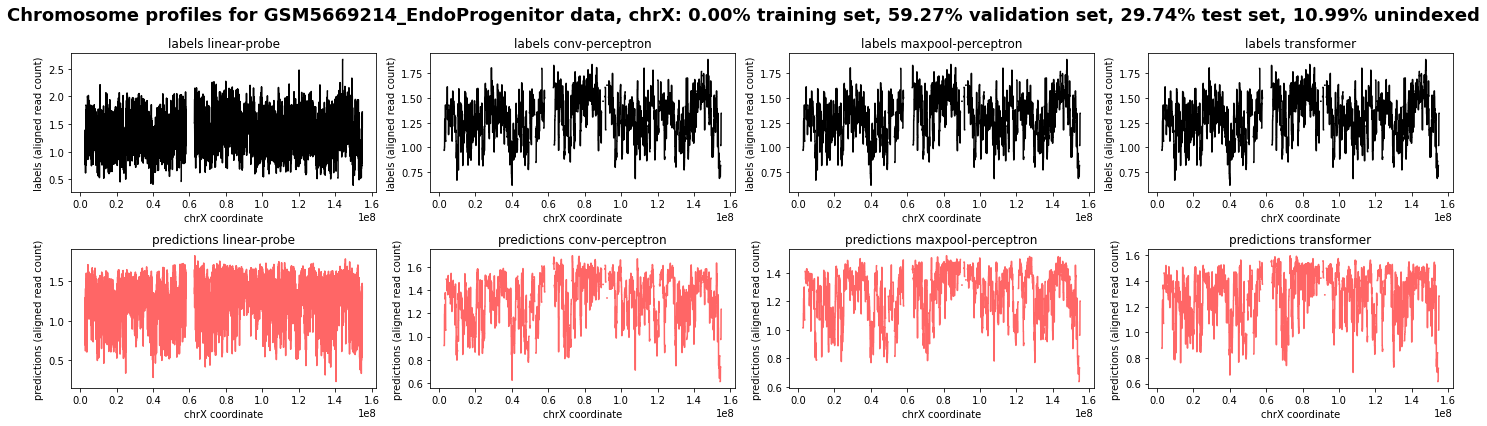

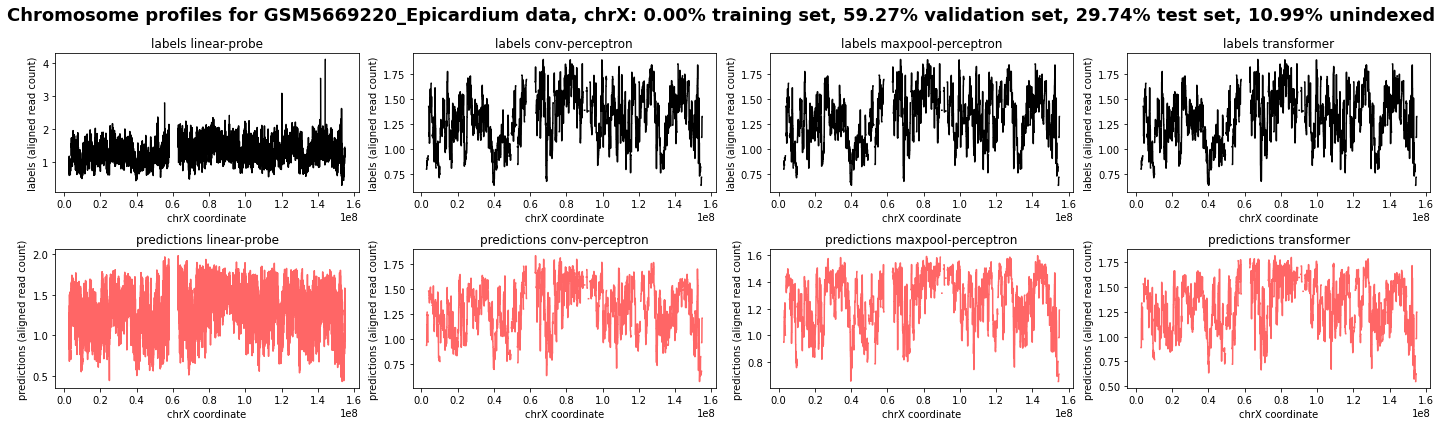

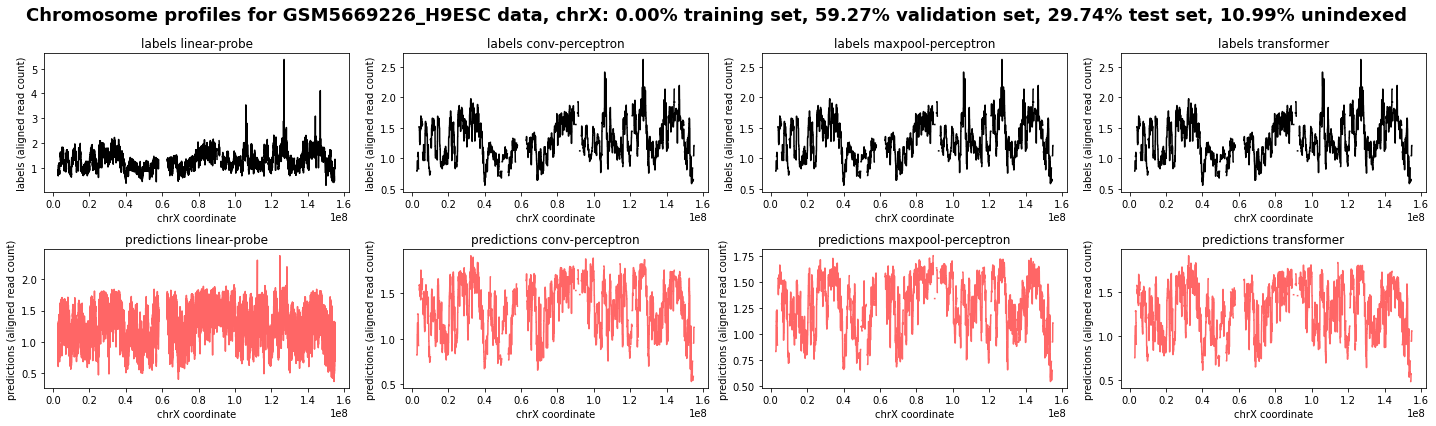

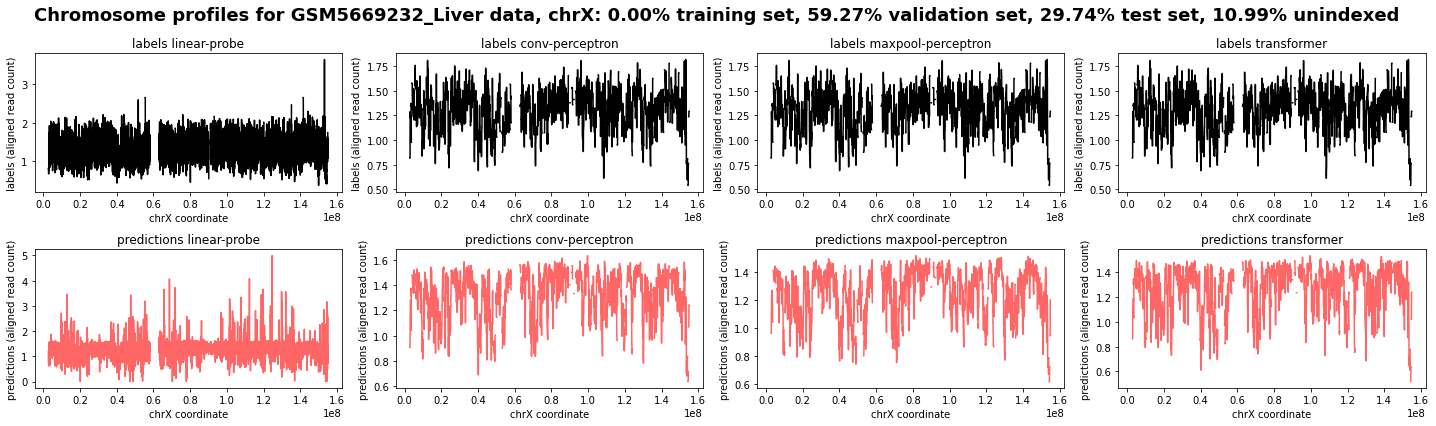

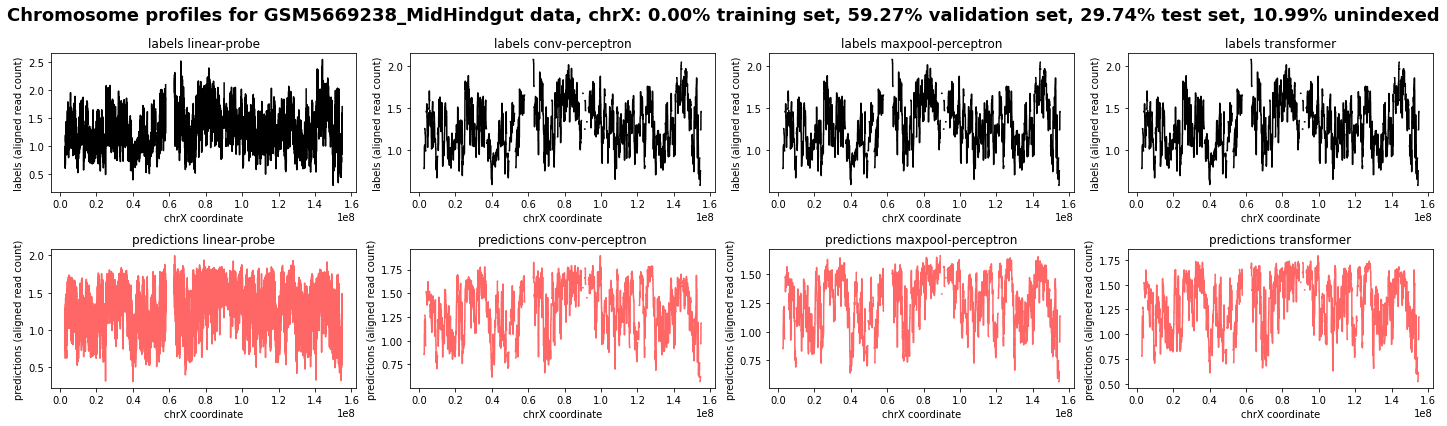

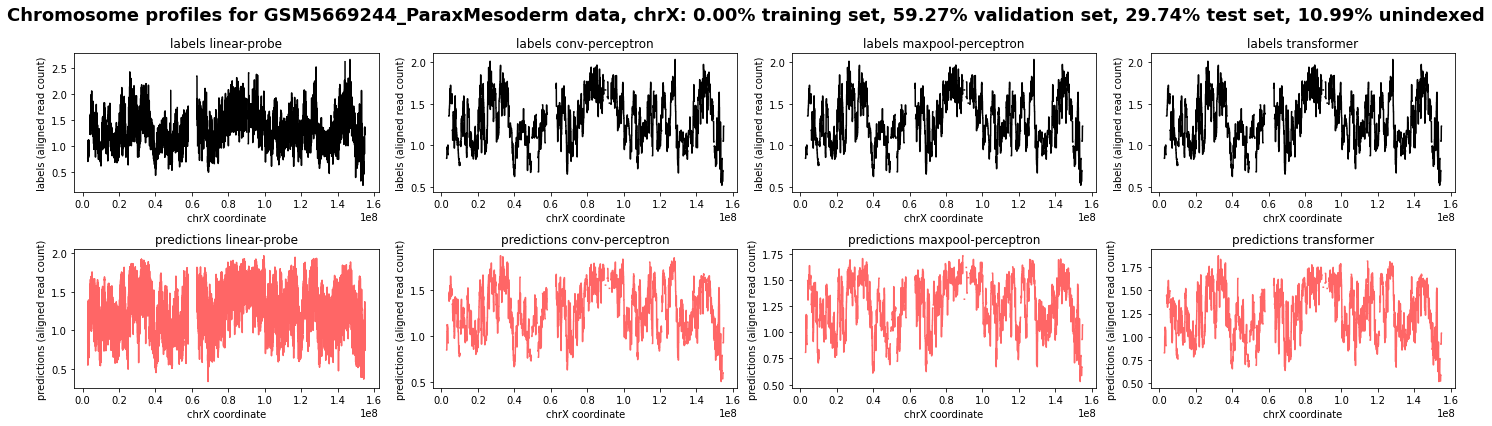

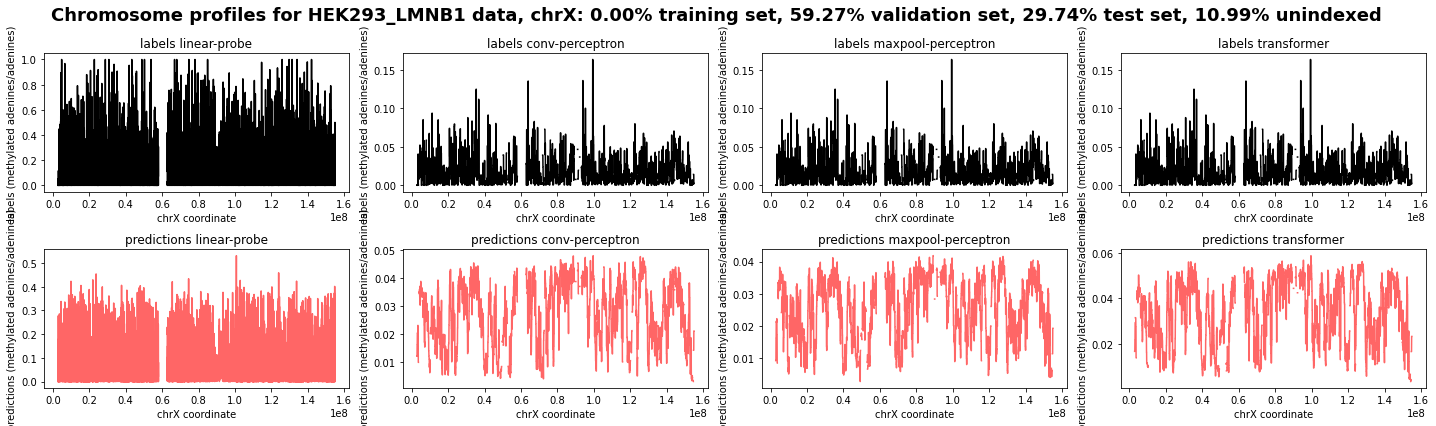

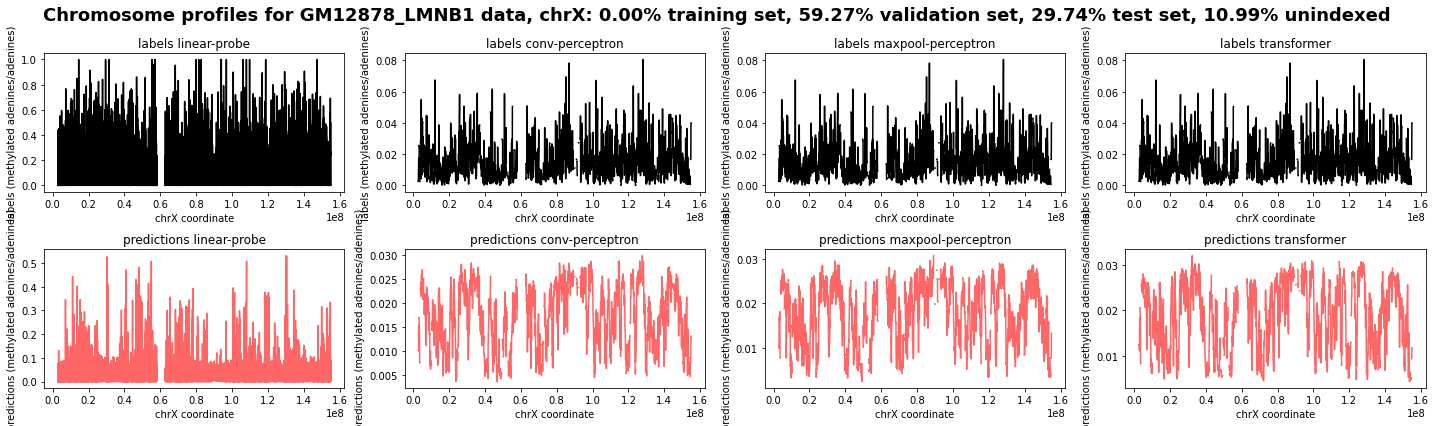

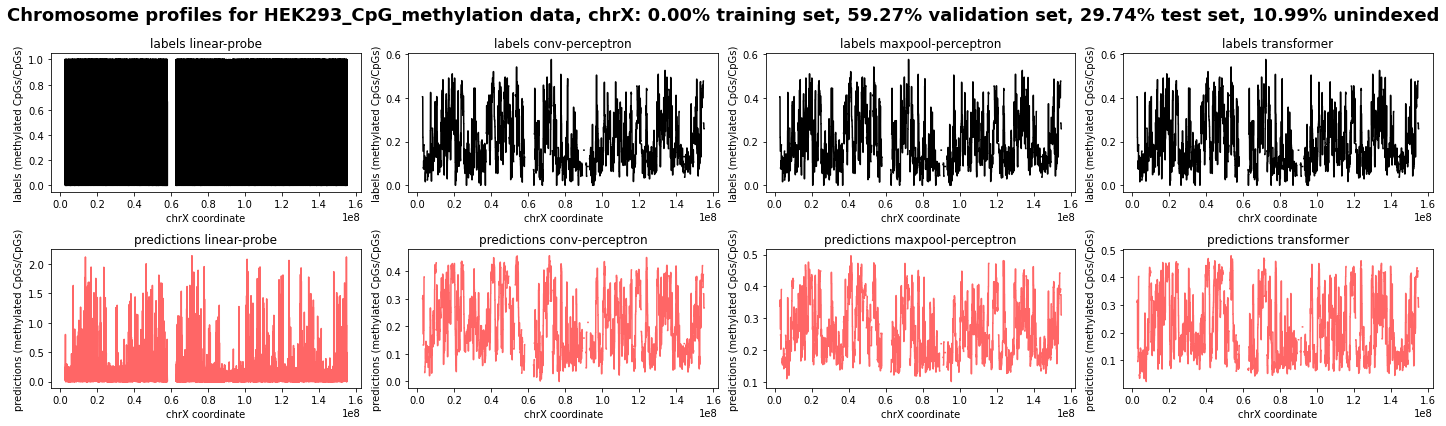

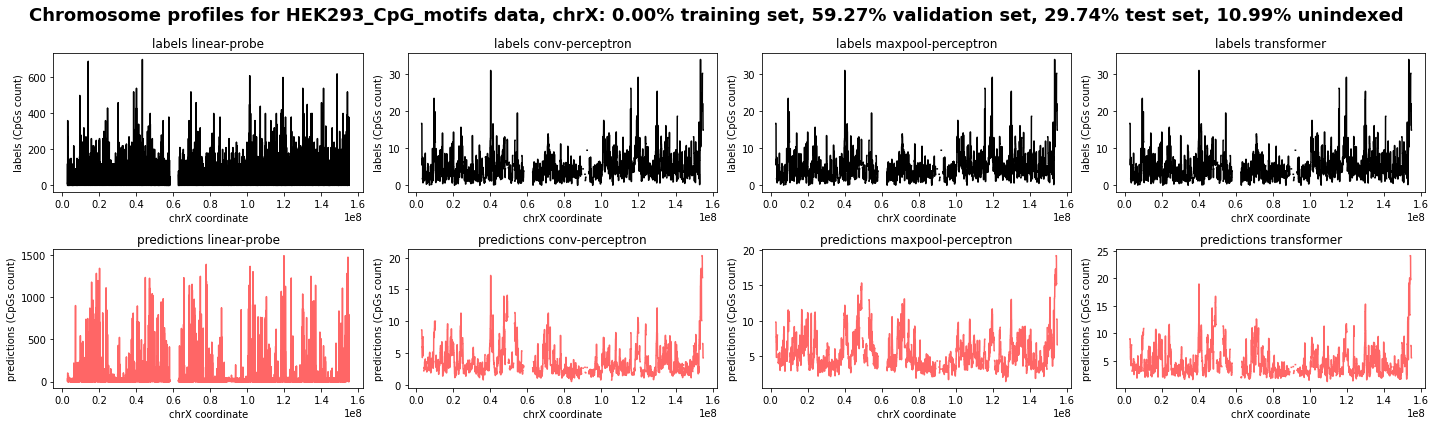

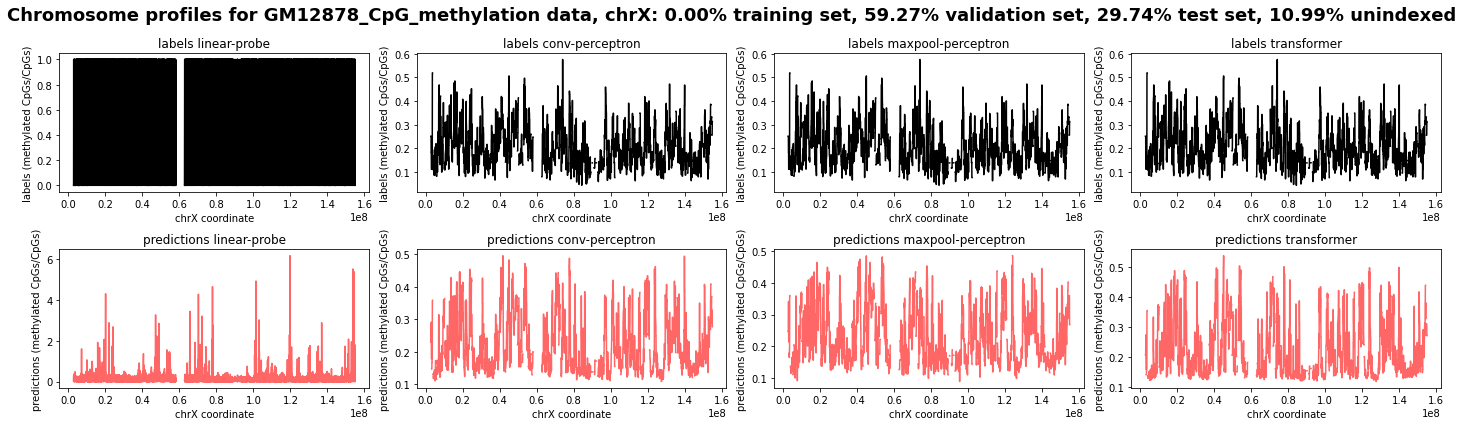

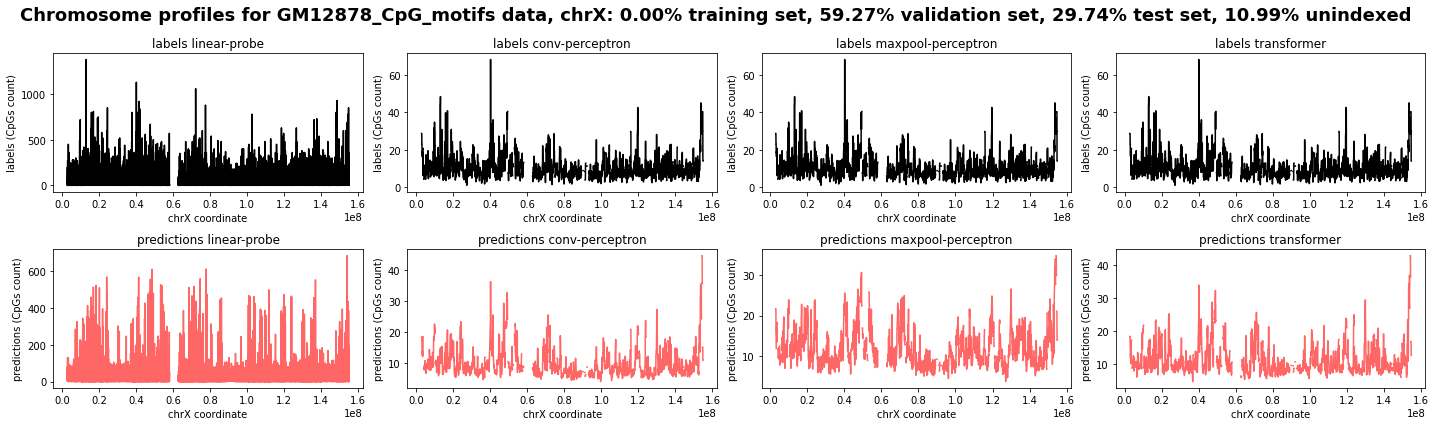

In [12]:
colors = {0: '1.0', 1: '0.9', 2: '0.75', 3: '0.5'}
def apply_fill_between(ax, x_coords, y_data, split_array, colors):
    start_idx = 0
    for i in range(1, len(split_array)):
        if split_array[i] != split_array[start_idx]:
            ax.fill_between(x=x_coords[start_idx:i], y1=y_data[start_idx:i], color=colors[split_array[start_idx]])
            start_idx = i
    
    ax.fill_between(x_coords[start_idx:], y_data[start_idx:], color=colors[split_array[start_idx]])


for plot_chrom in plot_chroms:
    if plot_chrom not in ['chr1','chr14','chrX']:
        print('skipping',plot_chrom,'to make notebook small enough to view!')
        continue
    (
    plot_xcoord,
    plot_array_low_res,
    plot_array_high_res,
    output_arrays,
    cm_lads_array,
    fl_lads_array,
    test_train_split_array,
    ) = chrom_results[plot_chrom]
    for i,track_name in enumerate(all_tracks):
        scaling = scaling_by_track[i]
        axlabel = data_label_by_track[i]
        fig1, axs1 = plt.subplots(2,4,figsize=(20,6))
        fig1.suptitle(f'Chromosome profiles for {track_name} data, {plot_chrom}: {sets_strings_dict[plot_chrom]}',fontweight='bold',size=18)
        for idx,(key,output_array) in enumerate(output_arrays.items()):
            if h5_files_dict[key][1]=='128bp_bins':
                axs1[0,idx].plot(plot_xcoord,plot_array_high_res[:,i]*scaling,'k',label='128bp bin labels')  
                axs1[1,idx].plot(plot_xcoord,output_array[:,i]*scaling,'r-',alpha=0.6,label='128bp bin predictions')
            elif h5_files_dict[key][1]=='single_bin':
                axs1[0,idx].plot(plot_xcoord,plot_array_low_res[:,i]*scaling,'k',label='114kbp bin labels')
                axs1[1,idx].plot(plot_xcoord,output_array[:,i]*scaling,'r-',alpha=0.6,label='114kbp bin predictions')
            axs1[0,idx].set_title(f'labels {key}')
            axs1[1,idx].set_title(f'predictions {key}')
            axs1[0,idx].set_ylabel(f'labels {axlabel}')
            axs1[1,idx].set_ylabel(f'predictions {axlabel}')
            axs1[0,idx].set_xlabel(f'{plot_chrom} coordinate')
            axs1[1,idx].set_xlabel(f'{plot_chrom} coordinate')
#             axs1[idx].legend(loc="upper center")
        plt.tight_layout()
        plt.show()